##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Intro to Autoencoders

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/generative/autoencoder">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/autoencoder.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/generative/autoencoder.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial introduces autoencoders with three examples: the basics, image denoising, and anomaly detection.

An autoencoder is a special type of neural network that is trained to copy its input to its output. For example, given an image of a handwritten digit, an autoencoder first encodes the image into a lower dimensional latent representation, then decodes the latent representation back to an image. An autoencoder learns to compress the data while minimizing the reconstruction error. 

To learn more about autoencoders, please consider reading chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.

## Import TensorFlow and other libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

2023-11-16 03:43:50.707030: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-16 03:43:50.707079: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-16 03:43:50.708681: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels. 

In [3]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

 8192/29515 [=======>......................] - ETA: 0s

29515/29515 [==============================] - 0s 0us/step


    8192/26421880 [..............................] - ETA: 0s

 4202496/26421880 [===>..........................] - ETA: 0s

17047552/26421880 [==================>...........] - ETA: 0s

26421880/26421880 [==============================] - 0s 0us/step


5148/5148 [==============================] - 0s 0us/step


   8192/4422102 [..............................] - ETA: 0s

4422102/4422102 [==============================] - 0s 0us/step


(60000, 28, 28)
(10000, 28, 28)


## First example: Basic autoencoder
![Basic autoencoder results](images/intro_autoencoder_result.png)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [4]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)


In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [6]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10


I0000 00:00:1700106238.272372   40695 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   1/1875 [..............................] - ETA: 46:51 - loss: 0.1723

  26/1875 [..............................] - ETA: 3s - loss: 0.1259   

  52/1875 [..............................] - ETA: 3s - loss: 0.1017

  79/1875 [>.............................] - ETA: 3s - loss: 0.0872

 106/1875 [>.............................] - ETA: 3s - loss: 0.0783

 132/1875 [=>............................] - ETA: 3s - loss: 0.0723

 159/1875 [=>............................] - ETA: 3s - loss: 0.0670

 185/1875 [=>............................] - ETA: 3s - loss: 0.0631

 211/1875 [==>...........................] - ETA: 3s - loss: 0.0598

 237/1875 [==>...........................] - ETA: 3s - loss: 0.0570

 263/1875 [===>..........................] - ETA: 3s - loss: 0.0546

 289/1875 [===>..........................] - ETA: 3s - loss: 0.0526

 316/1875 [====>.........................] - ETA: 3s - loss: 0.0507

 342/1875 [====>.........................] - ETA: 2s - loss: 0.0491

 369/1875 [====>.........................] - ETA: 2s - loss: 0.0477

 396/1875 [=====>........................] - ETA: 2s - loss: 0.0463

 423/1875 [=====>........................] - ETA: 2s - loss: 0.0450

 450/1875 [======>.......................] - ETA: 2s - loss: 0.0438

 477/1875 [======>.......................] - ETA: 2s - loss: 0.0428

 504/1875 [=======>......................] - ETA: 2s - loss: 0.0418

 532/1875 [=======>......................] - ETA: 2s - loss: 0.0409

 559/1875 [=======>......................] - ETA: 2s - loss: 0.0401

 587/1875 [========>.....................] - ETA: 2s - loss: 0.0393

 614/1875 [========>.....................] - ETA: 2s - loss: 0.0386

 641/1875 [=========>....................] - ETA: 2s - loss: 0.0379

 668/1875 [=========>....................] - ETA: 2s - loss: 0.0372

 696/1875 [==========>...................] - ETA: 2s - loss: 0.0366

 724/1875 [==========>...................] - ETA: 2s - loss: 0.0360

 752/1875 [===========>..................] - ETA: 2s - loss: 0.0354

 779/1875 [===========>..................] - ETA: 2s - loss: 0.0349

 806/1875 [===========>..................] - ETA: 2s - loss: 0.0344

 833/1875 [============>.................] - ETA: 1s - loss: 0.0339

 861/1875 [============>.................] - ETA: 1s - loss: 0.0334

 888/1875 [=============>................] - ETA: 1s - loss: 0.0329

 916/1875 [=============>................] - ETA: 1s - loss: 0.0325

 943/1875 [==============>...............] - ETA: 1s - loss: 0.0321

 970/1875 [==============>...............] - ETA: 1s - loss: 0.0317

 997/1875 [==============>...............] - ETA: 1s - loss: 0.0313

1024/1875 [===============>..............] - ETA: 1s - loss: 0.0309

1051/1875 [===============>..............] - ETA: 1s - loss: 0.0305

1078/1875 [================>.............] - ETA: 1s - loss: 0.0302

1105/1875 [================>.............] - ETA: 1s - loss: 0.0298

1132/1875 [=================>............] - ETA: 1s - loss: 0.0295

1159/1875 [=================>............] - ETA: 1s - loss: 0.0292

1185/1875 [=================>............] - ETA: 1s - loss: 0.0289

1212/1875 [==================>...........] - ETA: 1s - loss: 0.0287

1240/1875 [==================>...........] - ETA: 1s - loss: 0.0284

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0281

1293/1875 [===================>..........] - ETA: 1s - loss: 0.0278

1320/1875 [====================>.........] - ETA: 1s - loss: 0.0276

1347/1875 [====================>.........] - ETA: 0s - loss: 0.0273

1374/1875 [====================>.........] - ETA: 0s - loss: 0.0271

1401/1875 [=====================>........] - ETA: 0s - loss: 0.0269

1428/1875 [=====================>........] - ETA: 0s - loss: 0.0266

1455/1875 [======================>.......] - ETA: 0s - loss: 0.0264

1482/1875 [======================>.......] - ETA: 0s - loss: 0.0262

1509/1875 [=======================>......] - ETA: 0s - loss: 0.0260

1537/1875 [=======================>......] - ETA: 0s - loss: 0.0258

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0256

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0254

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0252

1649/1875 [=========================>....] - ETA: 0s - loss: 0.0250

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0248

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0246

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0245

1758/1875 [===========================>..] - ETA: 0s - loss: 0.0243

1785/1875 [===========================>..] - ETA: 0s - loss: 0.0241

1812/1875 [===========================>..] - ETA: 0s - loss: 0.0240

1838/1875 [============================>.] - ETA: 0s - loss: 0.0238

1865/1875 [============================>.] - ETA: 0s - loss: 0.0237

1875/1875 [==============================] - 6s 2ms/step - loss: 0.0236 - val_loss: 0.0132


Epoch 2/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0136

  27/1875 [..............................] - ETA: 3s - loss: 0.0136

  53/1875 [..............................] - ETA: 3s - loss: 0.0134

  79/1875 [>.............................] - ETA: 3s - loss: 0.0134

 105/1875 [>.............................] - ETA: 3s - loss: 0.0132

 131/1875 [=>............................] - ETA: 3s - loss: 0.0132

 158/1875 [=>............................] - ETA: 3s - loss: 0.0132

 185/1875 [=>............................] - ETA: 3s - loss: 0.0132

 213/1875 [==>...........................] - ETA: 3s - loss: 0.0131

 241/1875 [==>...........................] - ETA: 3s - loss: 0.0130

 269/1875 [===>..........................] - ETA: 3s - loss: 0.0130

 297/1875 [===>..........................] - ETA: 2s - loss: 0.0129

 324/1875 [====>.........................] - ETA: 2s - loss: 0.0129

 351/1875 [====>.........................] - ETA: 2s - loss: 0.0128

 378/1875 [=====>........................] - ETA: 2s - loss: 0.0128

 405/1875 [=====>........................] - ETA: 2s - loss: 0.0127

 431/1875 [=====>........................] - ETA: 2s - loss: 0.0127

 458/1875 [======>.......................] - ETA: 2s - loss: 0.0127

 485/1875 [======>.......................] - ETA: 2s - loss: 0.0126

 512/1875 [=======>......................] - ETA: 2s - loss: 0.0126

 538/1875 [=======>......................] - ETA: 2s - loss: 0.0126

 565/1875 [========>.....................] - ETA: 2s - loss: 0.0126

 592/1875 [========>.....................] - ETA: 2s - loss: 0.0125

 618/1875 [========>.....................] - ETA: 2s - loss: 0.0125

 644/1875 [=========>....................] - ETA: 2s - loss: 0.0125

 671/1875 [=========>....................] - ETA: 2s - loss: 0.0125

 697/1875 [==========>...................] - ETA: 2s - loss: 0.0125

 724/1875 [==========>...................] - ETA: 2s - loss: 0.0124

 750/1875 [===========>..................] - ETA: 2s - loss: 0.0124

 776/1875 [===========>..................] - ETA: 2s - loss: 0.0124

 803/1875 [===========>..................] - ETA: 2s - loss: 0.0124

 830/1875 [============>.................] - ETA: 1s - loss: 0.0124

 857/1875 [============>.................] - ETA: 1s - loss: 0.0124

 884/1875 [=============>................] - ETA: 1s - loss: 0.0123

 911/1875 [=============>................] - ETA: 1s - loss: 0.0123

 939/1875 [==============>...............] - ETA: 1s - loss: 0.0123

 967/1875 [==============>...............] - ETA: 1s - loss: 0.0123

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0122

1022/1875 [===============>..............] - ETA: 1s - loss: 0.0122

1049/1875 [===============>..............] - ETA: 1s - loss: 0.0122

1076/1875 [================>.............] - ETA: 1s - loss: 0.0122

1103/1875 [================>.............] - ETA: 1s - loss: 0.0122

1130/1875 [=================>............] - ETA: 1s - loss: 0.0122

1157/1875 [=================>............] - ETA: 1s - loss: 0.0121

1185/1875 [=================>............] - ETA: 1s - loss: 0.0121

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0121

1239/1875 [==================>...........] - ETA: 1s - loss: 0.0121

1266/1875 [===================>..........] - ETA: 1s - loss: 0.0121

1294/1875 [===================>..........] - ETA: 1s - loss: 0.0120

1321/1875 [====================>.........] - ETA: 1s - loss: 0.0120

1348/1875 [====================>.........] - ETA: 0s - loss: 0.0120

1375/1875 [=====================>........] - ETA: 0s - loss: 0.0120

1402/1875 [=====================>........] - ETA: 0s - loss: 0.0120

1429/1875 [=====================>........] - ETA: 0s - loss: 0.0119

1456/1875 [======================>.......] - ETA: 0s - loss: 0.0119

1483/1875 [======================>.......] - ETA: 0s - loss: 0.0119

1510/1875 [=======================>......] - ETA: 0s - loss: 0.0119

1538/1875 [=======================>......] - ETA: 0s - loss: 0.0119

1566/1875 [========================>.....] - ETA: 0s - loss: 0.0119

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0119

1621/1875 [========================>.....] - ETA: 0s - loss: 0.0118

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0118

1674/1875 [=========================>....] - ETA: 0s - loss: 0.0118

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0118

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0118

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0118

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0118

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0117

1838/1875 [============================>.] - ETA: 0s - loss: 0.0117

1865/1875 [============================>.] - ETA: 0s - loss: 0.0117

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0117 - val_loss: 0.0107


Epoch 3/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0113

  28/1875 [..............................] - ETA: 3s - loss: 0.0102

  55/1875 [..............................] - ETA: 3s - loss: 0.0103

  83/1875 [>.............................] - ETA: 3s - loss: 0.0102

 110/1875 [>.............................] - ETA: 3s - loss: 0.0103

 137/1875 [=>............................] - ETA: 3s - loss: 0.0103

 164/1875 [=>............................] - ETA: 3s - loss: 0.0103

 191/1875 [==>...........................] - ETA: 3s - loss: 0.0104

 219/1875 [==>...........................] - ETA: 3s - loss: 0.0104

 246/1875 [==>...........................] - ETA: 3s - loss: 0.0104

 274/1875 [===>..........................] - ETA: 2s - loss: 0.0105

 301/1875 [===>..........................] - ETA: 2s - loss: 0.0105

 329/1875 [====>.........................] - ETA: 2s - loss: 0.0105

 357/1875 [====>.........................] - ETA: 2s - loss: 0.0104

 384/1875 [=====>........................] - ETA: 2s - loss: 0.0104

 411/1875 [=====>........................] - ETA: 2s - loss: 0.0104

 438/1875 [======>.......................] - ETA: 2s - loss: 0.0104

 465/1875 [======>.......................] - ETA: 2s - loss: 0.0104

 493/1875 [======>.......................] - ETA: 2s - loss: 0.0104

 520/1875 [=======>......................] - ETA: 2s - loss: 0.0103

 547/1875 [=======>......................] - ETA: 2s - loss: 0.0103

 575/1875 [========>.....................] - ETA: 2s - loss: 0.0103

 603/1875 [========>.....................] - ETA: 2s - loss: 0.0103

 631/1875 [=========>....................] - ETA: 2s - loss: 0.0103

 659/1875 [=========>....................] - ETA: 2s - loss: 0.0103

 687/1875 [=========>....................] - ETA: 2s - loss: 0.0103

 716/1875 [==========>...................] - ETA: 2s - loss: 0.0103

 744/1875 [==========>...................] - ETA: 2s - loss: 0.0103

 772/1875 [===========>..................] - ETA: 2s - loss: 0.0103

 800/1875 [===========>..................] - ETA: 1s - loss: 0.0103

 827/1875 [============>.................] - ETA: 1s - loss: 0.0103

 854/1875 [============>.................] - ETA: 1s - loss: 0.0103

 881/1875 [=============>................] - ETA: 1s - loss: 0.0103

 908/1875 [=============>................] - ETA: 1s - loss: 0.0103

 933/1875 [=============>................] - ETA: 1s - loss: 0.0103

 961/1875 [==============>...............] - ETA: 1s - loss: 0.0103

 989/1875 [==============>...............] - ETA: 1s - loss: 0.0103

1018/1875 [===============>..............] - ETA: 1s - loss: 0.0103

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0103

1074/1875 [================>.............] - ETA: 1s - loss: 0.0103

1102/1875 [================>.............] - ETA: 1s - loss: 0.0103

1130/1875 [=================>............] - ETA: 1s - loss: 0.0103

1157/1875 [=================>............] - ETA: 1s - loss: 0.0103

1185/1875 [=================>............] - ETA: 1s - loss: 0.0103

1214/1875 [==================>...........] - ETA: 1s - loss: 0.0102

1243/1875 [==================>...........] - ETA: 1s - loss: 0.0102

1271/1875 [===================>..........] - ETA: 1s - loss: 0.0102

1298/1875 [===================>..........] - ETA: 1s - loss: 0.0102

1325/1875 [====================>.........] - ETA: 1s - loss: 0.0102

1352/1875 [====================>.........] - ETA: 0s - loss: 0.0102

1380/1875 [=====================>........] - ETA: 0s - loss: 0.0102

1408/1875 [=====================>........] - ETA: 0s - loss: 0.0102

1436/1875 [=====================>........] - ETA: 0s - loss: 0.0102

1464/1875 [======================>.......] - ETA: 0s - loss: 0.0102

1491/1875 [======================>.......] - ETA: 0s - loss: 0.0102

1519/1875 [=======================>......] - ETA: 0s - loss: 0.0102

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0102

1574/1875 [========================>.....] - ETA: 0s - loss: 0.0102

1602/1875 [========================>.....] - ETA: 0s - loss: 0.0102

1630/1875 [=========================>....] - ETA: 0s - loss: 0.0102

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0102

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0102

1713/1875 [==========================>...] - ETA: 0s - loss: 0.0102

1740/1875 [==========================>...] - ETA: 0s - loss: 0.0102

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0102

1796/1875 [===========================>..] - ETA: 0s - loss: 0.0102

1824/1875 [============================>.] - ETA: 0s - loss: 0.0101

1851/1875 [============================>.] - ETA: 0s - loss: 0.0101

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0101 - val_loss: 0.0098


Epoch 4/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0107

  27/1875 [..............................] - ETA: 3s - loss: 0.0098

  54/1875 [..............................] - ETA: 3s - loss: 0.0097

  81/1875 [>.............................] - ETA: 3s - loss: 0.0097

 108/1875 [>.............................] - ETA: 3s - loss: 0.0097

 134/1875 [=>............................] - ETA: 3s - loss: 0.0098

 161/1875 [=>............................] - ETA: 3s - loss: 0.0098

 189/1875 [==>...........................] - ETA: 3s - loss: 0.0098

 217/1875 [==>...........................] - ETA: 3s - loss: 0.0097

 243/1875 [==>...........................] - ETA: 3s - loss: 0.0097

 270/1875 [===>..........................] - ETA: 3s - loss: 0.0097

 297/1875 [===>..........................] - ETA: 2s - loss: 0.0097

 324/1875 [====>.........................] - ETA: 2s - loss: 0.0097

 350/1875 [====>.........................] - ETA: 2s - loss: 0.0097

 377/1875 [=====>........................] - ETA: 2s - loss: 0.0097

 404/1875 [=====>........................] - ETA: 2s - loss: 0.0097

 432/1875 [=====>........................] - ETA: 2s - loss: 0.0097

 459/1875 [======>.......................] - ETA: 2s - loss: 0.0097

 486/1875 [======>.......................] - ETA: 2s - loss: 0.0097

 513/1875 [=======>......................] - ETA: 2s - loss: 0.0097

 541/1875 [=======>......................] - ETA: 2s - loss: 0.0096

 569/1875 [========>.....................] - ETA: 2s - loss: 0.0096

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0096

 626/1875 [=========>....................] - ETA: 2s - loss: 0.0096

 654/1875 [=========>....................] - ETA: 2s - loss: 0.0096

 682/1875 [=========>....................] - ETA: 2s - loss: 0.0096

 711/1875 [==========>...................] - ETA: 2s - loss: 0.0096

 739/1875 [==========>...................] - ETA: 2s - loss: 0.0096

 764/1875 [===========>..................] - ETA: 2s - loss: 0.0096

 791/1875 [===========>..................] - ETA: 2s - loss: 0.0096

 819/1875 [============>.................] - ETA: 1s - loss: 0.0096

 847/1875 [============>.................] - ETA: 1s - loss: 0.0096

 875/1875 [=============>................] - ETA: 1s - loss: 0.0096

 904/1875 [=============>................] - ETA: 1s - loss: 0.0096

 932/1875 [=============>................] - ETA: 1s - loss: 0.0096

 960/1875 [==============>...............] - ETA: 1s - loss: 0.0096

 988/1875 [==============>...............] - ETA: 1s - loss: 0.0096

1016/1875 [===============>..............] - ETA: 1s - loss: 0.0096

1044/1875 [===============>..............] - ETA: 1s - loss: 0.0096

1073/1875 [================>.............] - ETA: 1s - loss: 0.0096

1101/1875 [================>.............] - ETA: 1s - loss: 0.0096

1129/1875 [=================>............] - ETA: 1s - loss: 0.0096

1157/1875 [=================>............] - ETA: 1s - loss: 0.0096

1185/1875 [=================>............] - ETA: 1s - loss: 0.0096

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0096

1241/1875 [==================>...........] - ETA: 1s - loss: 0.0096

1269/1875 [===================>..........] - ETA: 1s - loss: 0.0096

1297/1875 [===================>..........] - ETA: 1s - loss: 0.0096

1325/1875 [====================>.........] - ETA: 1s - loss: 0.0096

1353/1875 [====================>.........] - ETA: 0s - loss: 0.0096

1381/1875 [=====================>........] - ETA: 0s - loss: 0.0096

1409/1875 [=====================>........] - ETA: 0s - loss: 0.0096

1437/1875 [=====================>........] - ETA: 0s - loss: 0.0096

1465/1875 [======================>.......] - ETA: 0s - loss: 0.0096

1493/1875 [======================>.......] - ETA: 0s - loss: 0.0096

1521/1875 [=======================>......] - ETA: 0s - loss: 0.0096

1549/1875 [=======================>......] - ETA: 0s - loss: 0.0096

1577/1875 [========================>.....] - ETA: 0s - loss: 0.0096

1605/1875 [========================>.....] - ETA: 0s - loss: 0.0096

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0095

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0095

1744/1875 [==========================>...] - ETA: 0s - loss: 0.0095

1771/1875 [===========================>..] - ETA: 0s - loss: 0.0095

1798/1875 [===========================>..] - ETA: 0s - loss: 0.0095

1826/1875 [============================>.] - ETA: 0s - loss: 0.0095

1854/1875 [============================>.] - ETA: 0s - loss: 0.0095

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0095 - val_loss: 0.0095


Epoch 5/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0083

  27/1875 [..............................] - ETA: 3s - loss: 0.0094

  53/1875 [..............................] - ETA: 3s - loss: 0.0091

  79/1875 [>.............................] - ETA: 3s - loss: 0.0092

 105/1875 [>.............................] - ETA: 3s - loss: 0.0092

 131/1875 [=>............................] - ETA: 3s - loss: 0.0092

 157/1875 [=>............................] - ETA: 3s - loss: 0.0091

 183/1875 [=>............................] - ETA: 3s - loss: 0.0092

 209/1875 [==>...........................] - ETA: 3s - loss: 0.0093

 235/1875 [==>...........................] - ETA: 3s - loss: 0.0093

 261/1875 [===>..........................] - ETA: 3s - loss: 0.0093

 287/1875 [===>..........................] - ETA: 3s - loss: 0.0093

 313/1875 [====>.........................] - ETA: 3s - loss: 0.0093

 339/1875 [====>.........................] - ETA: 2s - loss: 0.0093

 366/1875 [====>.........................] - ETA: 2s - loss: 0.0093

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0093

 417/1875 [=====>........................] - ETA: 2s - loss: 0.0093

 443/1875 [======>.......................] - ETA: 2s - loss: 0.0093

 470/1875 [======>.......................] - ETA: 2s - loss: 0.0093

 497/1875 [======>.......................] - ETA: 2s - loss: 0.0093

 524/1875 [=======>......................] - ETA: 2s - loss: 0.0093

 550/1875 [=======>......................] - ETA: 2s - loss: 0.0093

 576/1875 [========>.....................] - ETA: 2s - loss: 0.0093

 602/1875 [========>.....................] - ETA: 2s - loss: 0.0093

 628/1875 [=========>....................] - ETA: 2s - loss: 0.0093

 654/1875 [=========>....................] - ETA: 2s - loss: 0.0093

 679/1875 [=========>....................] - ETA: 2s - loss: 0.0093

 705/1875 [==========>...................] - ETA: 2s - loss: 0.0093

 731/1875 [==========>...................] - ETA: 2s - loss: 0.0093

 757/1875 [===========>..................] - ETA: 2s - loss: 0.0093

 783/1875 [===========>..................] - ETA: 2s - loss: 0.0093

 809/1875 [===========>..................] - ETA: 2s - loss: 0.0093

 835/1875 [============>.................] - ETA: 2s - loss: 0.0093

 861/1875 [============>.................] - ETA: 1s - loss: 0.0093

 887/1875 [=============>................] - ETA: 1s - loss: 0.0093

 913/1875 [=============>................] - ETA: 1s - loss: 0.0093

 939/1875 [==============>...............] - ETA: 1s - loss: 0.0093

 964/1875 [==============>...............] - ETA: 1s - loss: 0.0093

 990/1875 [==============>...............] - ETA: 1s - loss: 0.0093

1016/1875 [===============>..............] - ETA: 1s - loss: 0.0093

1042/1875 [===============>..............] - ETA: 1s - loss: 0.0093

1068/1875 [================>.............] - ETA: 1s - loss: 0.0093

1094/1875 [================>.............] - ETA: 1s - loss: 0.0093

1120/1875 [================>.............] - ETA: 1s - loss: 0.0093

1146/1875 [=================>............] - ETA: 1s - loss: 0.0093

1172/1875 [=================>............] - ETA: 1s - loss: 0.0093

1198/1875 [==================>...........] - ETA: 1s - loss: 0.0093

1224/1875 [==================>...........] - ETA: 1s - loss: 0.0093

1251/1875 [===================>..........] - ETA: 1s - loss: 0.0093

1279/1875 [===================>..........] - ETA: 1s - loss: 0.0093

1306/1875 [===================>..........] - ETA: 1s - loss: 0.0093

1333/1875 [====================>.........] - ETA: 1s - loss: 0.0093

1360/1875 [====================>.........] - ETA: 1s - loss: 0.0093

1388/1875 [=====================>........] - ETA: 0s - loss: 0.0093

1416/1875 [=====================>........] - ETA: 0s - loss: 0.0093

1443/1875 [======================>.......] - ETA: 0s - loss: 0.0093

1470/1875 [======================>.......] - ETA: 0s - loss: 0.0093

1498/1875 [======================>.......] - ETA: 0s - loss: 0.0093

1526/1875 [=======================>......] - ETA: 0s - loss: 0.0093

1554/1875 [=======================>......] - ETA: 0s - loss: 0.0093

1582/1875 [========================>.....] - ETA: 0s - loss: 0.0093

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0093

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0093

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0093

1693/1875 [==========================>...] - ETA: 0s - loss: 0.0093

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0093

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0093

1776/1875 [===========================>..] - ETA: 0s - loss: 0.0093

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0093

1832/1875 [============================>.] - ETA: 0s - loss: 0.0093

1859/1875 [============================>.] - ETA: 0s - loss: 0.0093

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0093 - val_loss: 0.0093


Epoch 6/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0116

  27/1875 [..............................] - ETA: 3s - loss: 0.0093

  53/1875 [..............................] - ETA: 3s - loss: 0.0093

  79/1875 [>.............................] - ETA: 3s - loss: 0.0092

 105/1875 [>.............................] - ETA: 3s - loss: 0.0092

 131/1875 [=>............................] - ETA: 3s - loss: 0.0092

 157/1875 [=>............................] - ETA: 3s - loss: 0.0092

 183/1875 [=>............................] - ETA: 3s - loss: 0.0092

 209/1875 [==>...........................] - ETA: 3s - loss: 0.0091

 235/1875 [==>...........................] - ETA: 3s - loss: 0.0091

 262/1875 [===>..........................] - ETA: 3s - loss: 0.0091

 288/1875 [===>..........................] - ETA: 3s - loss: 0.0091

 314/1875 [====>.........................] - ETA: 3s - loss: 0.0091

 340/1875 [====>.........................] - ETA: 2s - loss: 0.0091

 366/1875 [====>.........................] - ETA: 2s - loss: 0.0091

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0092

 418/1875 [=====>........................] - ETA: 2s - loss: 0.0091

 444/1875 [======>.......................] - ETA: 2s - loss: 0.0091

 471/1875 [======>.......................] - ETA: 2s - loss: 0.0091

 498/1875 [======>.......................] - ETA: 2s - loss: 0.0091

 526/1875 [=======>......................] - ETA: 2s - loss: 0.0091

 554/1875 [=======>......................] - ETA: 2s - loss: 0.0091

 582/1875 [========>.....................] - ETA: 2s - loss: 0.0091

 610/1875 [========>.....................] - ETA: 2s - loss: 0.0091

 638/1875 [=========>....................] - ETA: 2s - loss: 0.0091

 665/1875 [=========>....................] - ETA: 2s - loss: 0.0091

 693/1875 [==========>...................] - ETA: 2s - loss: 0.0091

 720/1875 [==========>...................] - ETA: 2s - loss: 0.0091

 748/1875 [==========>...................] - ETA: 2s - loss: 0.0091

 776/1875 [===========>..................] - ETA: 2s - loss: 0.0091

 803/1875 [===========>..................] - ETA: 2s - loss: 0.0091

 830/1875 [============>.................] - ETA: 1s - loss: 0.0091

 857/1875 [============>.................] - ETA: 1s - loss: 0.0091

 884/1875 [=============>................] - ETA: 1s - loss: 0.0091

 911/1875 [=============>................] - ETA: 1s - loss: 0.0091

 937/1875 [=============>................] - ETA: 1s - loss: 0.0091

 964/1875 [==============>...............] - ETA: 1s - loss: 0.0091

 991/1875 [==============>...............] - ETA: 1s - loss: 0.0091

1018/1875 [===============>..............] - ETA: 1s - loss: 0.0091

1045/1875 [===============>..............] - ETA: 1s - loss: 0.0091

1072/1875 [================>.............] - ETA: 1s - loss: 0.0091

1099/1875 [================>.............] - ETA: 1s - loss: 0.0091

1127/1875 [=================>............] - ETA: 1s - loss: 0.0091

1154/1875 [=================>............] - ETA: 1s - loss: 0.0091

1181/1875 [=================>............] - ETA: 1s - loss: 0.0091

1208/1875 [==================>...........] - ETA: 1s - loss: 0.0091

1235/1875 [==================>...........] - ETA: 1s - loss: 0.0091

1262/1875 [===================>..........] - ETA: 1s - loss: 0.0091

1289/1875 [===================>..........] - ETA: 1s - loss: 0.0091

1316/1875 [====================>.........] - ETA: 1s - loss: 0.0091

1343/1875 [====================>.........] - ETA: 1s - loss: 0.0091

1370/1875 [====================>.........] - ETA: 0s - loss: 0.0091

1397/1875 [=====================>........] - ETA: 0s - loss: 0.0091

1425/1875 [=====================>........] - ETA: 0s - loss: 0.0091

1453/1875 [======================>.......] - ETA: 0s - loss: 0.0091

1480/1875 [======================>.......] - ETA: 0s - loss: 0.0091

1506/1875 [=======================>......] - ETA: 0s - loss: 0.0091

1533/1875 [=======================>......] - ETA: 0s - loss: 0.0091

1561/1875 [=======================>......] - ETA: 0s - loss: 0.0091

1588/1875 [========================>.....] - ETA: 0s - loss: 0.0091

1615/1875 [========================>.....] - ETA: 0s - loss: 0.0091

1642/1875 [=========================>....] - ETA: 0s - loss: 0.0091

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0091

1697/1875 [==========================>...] - ETA: 0s - loss: 0.0091

1724/1875 [==========================>...] - ETA: 0s - loss: 0.0091

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0091

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0091

1805/1875 [===========================>..] - ETA: 0s - loss: 0.0091

1832/1875 [============================>.] - ETA: 0s - loss: 0.0091

1859/1875 [============================>.] - ETA: 0s - loss: 0.0091

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0091 - val_loss: 0.0091


Epoch 7/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0095

  28/1875 [..............................] - ETA: 3s - loss: 0.0091

  54/1875 [..............................] - ETA: 3s - loss: 0.0092

  81/1875 [>.............................] - ETA: 3s - loss: 0.0091

 108/1875 [>.............................] - ETA: 3s - loss: 0.0090

 135/1875 [=>............................] - ETA: 3s - loss: 0.0090

 162/1875 [=>............................] - ETA: 3s - loss: 0.0090

 189/1875 [==>...........................] - ETA: 3s - loss: 0.0090

 215/1875 [==>...........................] - ETA: 3s - loss: 0.0091

 240/1875 [==>...........................] - ETA: 3s - loss: 0.0091

 266/1875 [===>..........................] - ETA: 3s - loss: 0.0091

 292/1875 [===>..........................] - ETA: 3s - loss: 0.0091

 318/1875 [====>.........................] - ETA: 3s - loss: 0.0091

 345/1875 [====>.........................] - ETA: 2s - loss: 0.0090

 372/1875 [====>.........................] - ETA: 2s - loss: 0.0090

 398/1875 [=====>........................] - ETA: 2s - loss: 0.0091

 425/1875 [=====>........................] - ETA: 2s - loss: 0.0091

 452/1875 [======>.......................] - ETA: 2s - loss: 0.0091

 479/1875 [======>.......................] - ETA: 2s - loss: 0.0091

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0091

 533/1875 [=======>......................] - ETA: 2s - loss: 0.0091

 561/1875 [=======>......................] - ETA: 2s - loss: 0.0090

 589/1875 [========>.....................] - ETA: 2s - loss: 0.0090

 617/1875 [========>.....................] - ETA: 2s - loss: 0.0090

 644/1875 [=========>....................] - ETA: 2s - loss: 0.0090

 671/1875 [=========>....................] - ETA: 2s - loss: 0.0090

 697/1875 [==========>...................] - ETA: 2s - loss: 0.0090

 724/1875 [==========>...................] - ETA: 2s - loss: 0.0090

 751/1875 [===========>..................] - ETA: 2s - loss: 0.0090

 777/1875 [===========>..................] - ETA: 2s - loss: 0.0090

 803/1875 [===========>..................] - ETA: 2s - loss: 0.0090

 829/1875 [============>.................] - ETA: 1s - loss: 0.0090

 857/1875 [============>.................] - ETA: 1s - loss: 0.0090

 884/1875 [=============>................] - ETA: 1s - loss: 0.0090

 911/1875 [=============>................] - ETA: 1s - loss: 0.0090

 937/1875 [=============>................] - ETA: 1s - loss: 0.0090

 964/1875 [==============>...............] - ETA: 1s - loss: 0.0090

 991/1875 [==============>...............] - ETA: 1s - loss: 0.0090

1019/1875 [===============>..............] - ETA: 1s - loss: 0.0090

1047/1875 [===============>..............] - ETA: 1s - loss: 0.0090

1074/1875 [================>.............] - ETA: 1s - loss: 0.0090

1102/1875 [================>.............] - ETA: 1s - loss: 0.0090

1129/1875 [=================>............] - ETA: 1s - loss: 0.0090

1157/1875 [=================>............] - ETA: 1s - loss: 0.0090

1185/1875 [=================>............] - ETA: 1s - loss: 0.0090

1212/1875 [==================>...........] - ETA: 1s - loss: 0.0090

1239/1875 [==================>...........] - ETA: 1s - loss: 0.0090

1266/1875 [===================>..........] - ETA: 1s - loss: 0.0090

1293/1875 [===================>..........] - ETA: 1s - loss: 0.0090

1320/1875 [====================>.........] - ETA: 1s - loss: 0.0090

1347/1875 [====================>.........] - ETA: 0s - loss: 0.0090

1373/1875 [====================>.........] - ETA: 0s - loss: 0.0090

1400/1875 [=====================>........] - ETA: 0s - loss: 0.0090

1427/1875 [=====================>........] - ETA: 0s - loss: 0.0090

1454/1875 [======================>.......] - ETA: 0s - loss: 0.0090

1482/1875 [======================>.......] - ETA: 0s - loss: 0.0090

1510/1875 [=======================>......] - ETA: 0s - loss: 0.0090

1537/1875 [=======================>......] - ETA: 0s - loss: 0.0090

1564/1875 [========================>.....] - ETA: 0s - loss: 0.0090

1591/1875 [========================>.....] - ETA: 0s - loss: 0.0090

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0090

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0090

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1725/1875 [==========================>...] - ETA: 0s - loss: 0.0090

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1779/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1806/1875 [===========================>..] - ETA: 0s - loss: 0.0090

1833/1875 [============================>.] - ETA: 0s - loss: 0.0090

1860/1875 [============================>.] - ETA: 0s - loss: 0.0090

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0090 - val_loss: 0.0091


Epoch 8/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0075

  28/1875 [..............................] - ETA: 3s - loss: 0.0086

  55/1875 [..............................] - ETA: 3s - loss: 0.0087

  82/1875 [>.............................] - ETA: 3s - loss: 0.0087

 110/1875 [>.............................] - ETA: 3s - loss: 0.0088

 138/1875 [=>............................] - ETA: 3s - loss: 0.0088

 166/1875 [=>............................] - ETA: 3s - loss: 0.0089

 194/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 222/1875 [==>...........................] - ETA: 3s - loss: 0.0089

 250/1875 [===>..........................] - ETA: 3s - loss: 0.0089

 278/1875 [===>..........................] - ETA: 2s - loss: 0.0089

 306/1875 [===>..........................] - ETA: 2s - loss: 0.0089

 334/1875 [====>.........................] - ETA: 2s - loss: 0.0089

 362/1875 [====>.........................] - ETA: 2s - loss: 0.0089

 390/1875 [=====>........................] - ETA: 2s - loss: 0.0089

 418/1875 [=====>........................] - ETA: 2s - loss: 0.0089

 446/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 474/1875 [======>.......................] - ETA: 2s - loss: 0.0089

 502/1875 [=======>......................] - ETA: 2s - loss: 0.0089

 530/1875 [=======>......................] - ETA: 2s - loss: 0.0089

 558/1875 [=======>......................] - ETA: 2s - loss: 0.0089

 587/1875 [========>.....................] - ETA: 2s - loss: 0.0089

 616/1875 [========>.....................] - ETA: 2s - loss: 0.0089

 643/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 670/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 697/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 724/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 750/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 778/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 805/1875 [===========>..................] - ETA: 1s - loss: 0.0089

 832/1875 [============>.................] - ETA: 1s - loss: 0.0089

 858/1875 [============>.................] - ETA: 1s - loss: 0.0089

 884/1875 [=============>................] - ETA: 1s - loss: 0.0089

 911/1875 [=============>................] - ETA: 1s - loss: 0.0089

 939/1875 [==============>...............] - ETA: 1s - loss: 0.0089

 965/1875 [==============>...............] - ETA: 1s - loss: 0.0089

 992/1875 [==============>...............] - ETA: 1s - loss: 0.0089

1019/1875 [===============>..............] - ETA: 1s - loss: 0.0089

1046/1875 [===============>..............] - ETA: 1s - loss: 0.0089

1073/1875 [================>.............] - ETA: 1s - loss: 0.0089

1100/1875 [================>.............] - ETA: 1s - loss: 0.0089

1127/1875 [=================>............] - ETA: 1s - loss: 0.0089

1153/1875 [=================>............] - ETA: 1s - loss: 0.0089

1180/1875 [=================>............] - ETA: 1s - loss: 0.0089

1207/1875 [==================>...........] - ETA: 1s - loss: 0.0089

1235/1875 [==================>...........] - ETA: 1s - loss: 0.0089

1262/1875 [===================>..........] - ETA: 1s - loss: 0.0089

1289/1875 [===================>..........] - ETA: 1s - loss: 0.0089

1317/1875 [====================>.........] - ETA: 1s - loss: 0.0089

1345/1875 [====================>.........] - ETA: 0s - loss: 0.0089

1373/1875 [====================>.........] - ETA: 0s - loss: 0.0089

1401/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1429/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1458/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1487/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1516/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1544/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1572/1875 [========================>.....] - ETA: 0s - loss: 0.0089

1600/1875 [========================>.....] - ETA: 0s - loss: 0.0089

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1655/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1765/1875 [===========================>..] - ETA: 0s - loss: 0.0089

1793/1875 [===========================>..] - ETA: 0s - loss: 0.0089

1821/1875 [============================>.] - ETA: 0s - loss: 0.0089

1848/1875 [============================>.] - ETA: 0s - loss: 0.0089

1875/1875 [==============================] - ETA: 0s - loss: 0.0089

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0090


Epoch 9/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0099

  27/1875 [..............................] - ETA: 3s - loss: 0.0088

  53/1875 [..............................] - ETA: 3s - loss: 0.0089

  79/1875 [>.............................] - ETA: 3s - loss: 0.0088

 106/1875 [>.............................] - ETA: 3s - loss: 0.0087

 133/1875 [=>............................] - ETA: 3s - loss: 0.0087

 159/1875 [=>............................] - ETA: 3s - loss: 0.0088

 186/1875 [=>............................] - ETA: 3s - loss: 0.0088

 213/1875 [==>...........................] - ETA: 3s - loss: 0.0088

 240/1875 [==>...........................] - ETA: 3s - loss: 0.0088

 267/1875 [===>..........................] - ETA: 3s - loss: 0.0088

 295/1875 [===>..........................] - ETA: 3s - loss: 0.0088

 323/1875 [====>.........................] - ETA: 2s - loss: 0.0088

 351/1875 [====>.........................] - ETA: 2s - loss: 0.0088

 379/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 407/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 434/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 461/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 489/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 517/1875 [=======>......................] - ETA: 2s - loss: 0.0089

 546/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 574/1875 [========>.....................] - ETA: 2s - loss: 0.0089

 603/1875 [========>.....................] - ETA: 2s - loss: 0.0089

 631/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 659/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 687/1875 [=========>....................] - ETA: 2s - loss: 0.0089

 715/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 743/1875 [==========>...................] - ETA: 2s - loss: 0.0089

 771/1875 [===========>..................] - ETA: 2s - loss: 0.0089

 799/1875 [===========>..................] - ETA: 1s - loss: 0.0089

 827/1875 [============>.................] - ETA: 1s - loss: 0.0089

 855/1875 [============>.................] - ETA: 1s - loss: 0.0089

 883/1875 [=============>................] - ETA: 1s - loss: 0.0089

 910/1875 [=============>................] - ETA: 1s - loss: 0.0089

 938/1875 [==============>...............] - ETA: 1s - loss: 0.0089

 966/1875 [==============>...............] - ETA: 1s - loss: 0.0089

 994/1875 [==============>...............] - ETA: 1s - loss: 0.0089

1023/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1052/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1081/1875 [================>.............] - ETA: 1s - loss: 0.0088

1109/1875 [================>.............] - ETA: 1s - loss: 0.0088

1137/1875 [=================>............] - ETA: 1s - loss: 0.0088

1165/1875 [=================>............] - ETA: 1s - loss: 0.0089

1194/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1222/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1250/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1278/1875 [===================>..........] - ETA: 1s - loss: 0.0089

1305/1875 [===================>..........] - ETA: 1s - loss: 0.0089

1333/1875 [====================>.........] - ETA: 0s - loss: 0.0089

1361/1875 [====================>.........] - ETA: 0s - loss: 0.0089

1389/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1418/1875 [=====================>........] - ETA: 0s - loss: 0.0089

1446/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1474/1875 [======================>.......] - ETA: 0s - loss: 0.0089

1502/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1530/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1557/1875 [=======================>......] - ETA: 0s - loss: 0.0089

1585/1875 [========================>.....] - ETA: 0s - loss: 0.0089

1612/1875 [========================>.....] - ETA: 0s - loss: 0.0089

1637/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1663/1875 [=========================>....] - ETA: 0s - loss: 0.0089

1689/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1743/1875 [==========================>...] - ETA: 0s - loss: 0.0089

1770/1875 [===========================>..] - ETA: 0s - loss: 0.0089

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0089

1824/1875 [============================>.] - ETA: 0s - loss: 0.0089

1851/1875 [============================>.] - ETA: 0s - loss: 0.0089

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0089 - val_loss: 0.0089


Epoch 10/10


   1/1875 [..............................] - ETA: 5s - loss: 0.0071

  29/1875 [..............................] - ETA: 3s - loss: 0.0090

  57/1875 [..............................] - ETA: 3s - loss: 0.0088

  85/1875 [>.............................] - ETA: 3s - loss: 0.0088

 112/1875 [>.............................] - ETA: 3s - loss: 0.0089

 140/1875 [=>............................] - ETA: 3s - loss: 0.0088

 168/1875 [=>............................] - ETA: 3s - loss: 0.0088

 197/1875 [==>...........................] - ETA: 3s - loss: 0.0088

 225/1875 [==>...........................] - ETA: 3s - loss: 0.0088

 253/1875 [===>..........................] - ETA: 2s - loss: 0.0088

 281/1875 [===>..........................] - ETA: 2s - loss: 0.0088

 310/1875 [===>..........................] - ETA: 2s - loss: 0.0088

 338/1875 [====>.........................] - ETA: 2s - loss: 0.0088

 366/1875 [====>.........................] - ETA: 2s - loss: 0.0088

 393/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 421/1875 [=====>........................] - ETA: 2s - loss: 0.0088

 449/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 477/1875 [======>.......................] - ETA: 2s - loss: 0.0088

 505/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 534/1875 [=======>......................] - ETA: 2s - loss: 0.0088

 563/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 591/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 619/1875 [========>.....................] - ETA: 2s - loss: 0.0088

 647/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 674/1875 [=========>....................] - ETA: 2s - loss: 0.0088

 702/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 730/1875 [==========>...................] - ETA: 2s - loss: 0.0088

 759/1875 [===========>..................] - ETA: 2s - loss: 0.0088

 787/1875 [===========>..................] - ETA: 1s - loss: 0.0088

 815/1875 [============>.................] - ETA: 1s - loss: 0.0088

 843/1875 [============>.................] - ETA: 1s - loss: 0.0088

 871/1875 [============>.................] - ETA: 1s - loss: 0.0088

 900/1875 [=============>................] - ETA: 1s - loss: 0.0088

 929/1875 [=============>................] - ETA: 1s - loss: 0.0088

 957/1875 [==============>...............] - ETA: 1s - loss: 0.0088

 985/1875 [==============>...............] - ETA: 1s - loss: 0.0088

1013/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1041/1875 [===============>..............] - ETA: 1s - loss: 0.0088

1068/1875 [================>.............] - ETA: 1s - loss: 0.0088

1096/1875 [================>.............] - ETA: 1s - loss: 0.0088

1124/1875 [================>.............] - ETA: 1s - loss: 0.0088

1153/1875 [=================>............] - ETA: 1s - loss: 0.0088

1181/1875 [=================>............] - ETA: 1s - loss: 0.0088

1210/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1239/1875 [==================>...........] - ETA: 1s - loss: 0.0088

1267/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1295/1875 [===================>..........] - ETA: 1s - loss: 0.0088

1323/1875 [====================>.........] - ETA: 0s - loss: 0.0088

1350/1875 [====================>.........] - ETA: 0s - loss: 0.0088

1377/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1404/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1431/1875 [=====================>........] - ETA: 0s - loss: 0.0088

1458/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1485/1875 [======================>.......] - ETA: 0s - loss: 0.0088

1513/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0088

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1598/1875 [========================>.....] - ETA: 0s - loss: 0.0088

1626/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1654/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0088

1710/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1738/1875 [==========================>...] - ETA: 0s - loss: 0.0088

1766/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0088

1822/1875 [============================>.] - ETA: 0s - loss: 0.0088

1850/1875 [============================>.] - ETA: 0s - loss: 0.0088

1875/1875 [==============================] - 4s 2ms/step - loss: 0.0088 - val_loss: 0.0089


Now that the model is trained, let's test it by encoding and decoding images from the test set.

In [7]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

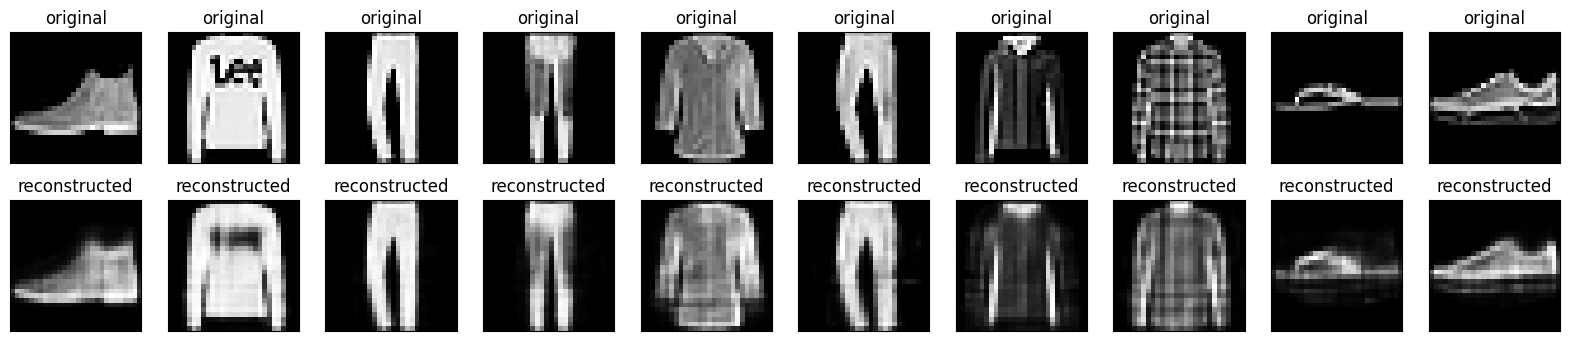

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Second example: Image denoising


![Image denoising results](images/image_denoise_fmnist_results.png)

An autoencoder can also be trained to remove noise from images. In the following section, you will create a noisy version of the Fashion MNIST dataset by applying random noise to each image. You will then train an autoencoder using the noisy image as input, and the original image as the target.

Let's reimport the dataset to omit the modifications made earlier.

In [9]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [10]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


Adding random noise to the images

In [11]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

Plot the noisy images.


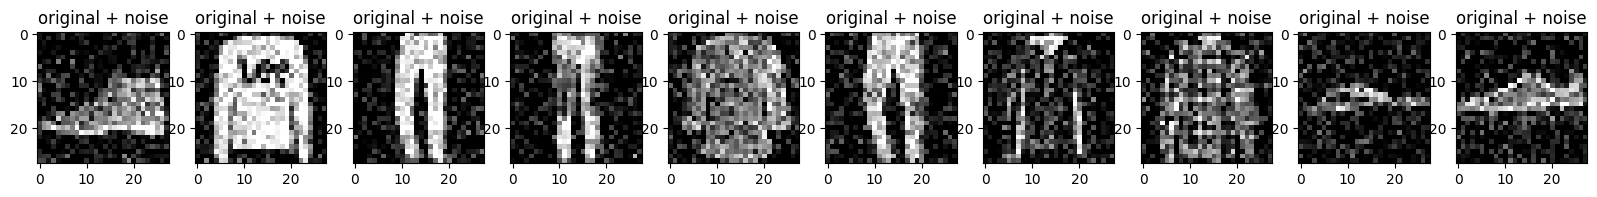

In [12]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### Define a convolutional autoencoder

In this example, you will train a convolutional autoencoder using  [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) layers in the `encoder`, and [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose) layers in the `decoder`.

In [13]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [14]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [15]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10


   1/1875 [..............................] - ETA: 1:23:08 - loss: 0.1668

  16/1875 [..............................] - ETA: 6s - loss: 0.1662     

  32/1875 [..............................] - ETA: 6s - loss: 0.1621

  49/1875 [..............................] - ETA: 5s - loss: 0.1528

  66/1875 [>.............................] - ETA: 5s - loss: 0.1375

  82/1875 [>.............................] - ETA: 5s - loss: 0.1211

  98/1875 [>.............................] - ETA: 5s - loss: 0.1075

 115/1875 [>.............................] - ETA: 5s - loss: 0.0963

 131/1875 [=>............................] - ETA: 5s - loss: 0.0880

 147/1875 [=>............................] - ETA: 5s - loss: 0.0813

 163/1875 [=>............................] - ETA: 5s - loss: 0.0757

 179/1875 [=>............................] - ETA: 5s - loss: 0.0710

 195/1875 [==>...........................] - ETA: 5s - loss: 0.0671

 211/1875 [==>...........................] - ETA: 5s - loss: 0.0637

 228/1875 [==>...........................] - ETA: 5s - loss: 0.0606

 245/1875 [==>...........................] - ETA: 5s - loss: 0.0578

 262/1875 [===>..........................] - ETA: 5s - loss: 0.0554

 279/1875 [===>..........................] - ETA: 5s - loss: 0.0533

 296/1875 [===>..........................] - ETA: 4s - loss: 0.0513

 313/1875 [====>.........................] - ETA: 4s - loss: 0.0495

 330/1875 [====>.........................] - ETA: 4s - loss: 0.0480

 347/1875 [====>.........................] - ETA: 4s - loss: 0.0465

 364/1875 [====>.........................] - ETA: 4s - loss: 0.0452

 381/1875 [=====>........................] - ETA: 4s - loss: 0.0440

 397/1875 [=====>........................] - ETA: 4s - loss: 0.0429

 413/1875 [=====>........................] - ETA: 4s - loss: 0.0419

 429/1875 [=====>........................] - ETA: 4s - loss: 0.0410

 446/1875 [======>.......................] - ETA: 4s - loss: 0.0401

 463/1875 [======>.......................] - ETA: 4s - loss: 0.0392

 479/1875 [======>.......................] - ETA: 4s - loss: 0.0385

 495/1875 [======>.......................] - ETA: 4s - loss: 0.0377

 512/1875 [=======>......................] - ETA: 4s - loss: 0.0370

 528/1875 [=======>......................] - ETA: 4s - loss: 0.0364

 544/1875 [=======>......................] - ETA: 4s - loss: 0.0358

 561/1875 [=======>......................] - ETA: 4s - loss: 0.0352

 578/1875 [========>.....................] - ETA: 4s - loss: 0.0346

 594/1875 [========>.....................] - ETA: 4s - loss: 0.0341

 610/1875 [========>.....................] - ETA: 3s - loss: 0.0336

 627/1875 [=========>....................] - ETA: 3s - loss: 0.0331

 643/1875 [=========>....................] - ETA: 3s - loss: 0.0327

 660/1875 [=========>....................] - ETA: 3s - loss: 0.0322

 676/1875 [=========>....................] - ETA: 3s - loss: 0.0318

 693/1875 [==========>...................] - ETA: 3s - loss: 0.0314

 709/1875 [==========>...................] - ETA: 3s - loss: 0.0310

 726/1875 [==========>...................] - ETA: 3s - loss: 0.0306

 742/1875 [==========>...................] - ETA: 3s - loss: 0.0303

 758/1875 [===========>..................] - ETA: 3s - loss: 0.0300

 775/1875 [===========>..................] - ETA: 3s - loss: 0.0296

 791/1875 [===========>..................] - ETA: 3s - loss: 0.0293

 808/1875 [===========>..................] - ETA: 3s - loss: 0.0290

 825/1875 [============>.................] - ETA: 3s - loss: 0.0287

 842/1875 [============>.................] - ETA: 3s - loss: 0.0284

 858/1875 [============>.................] - ETA: 3s - loss: 0.0282

 874/1875 [============>.................] - ETA: 3s - loss: 0.0279

 890/1875 [=============>................] - ETA: 3s - loss: 0.0276

 906/1875 [=============>................] - ETA: 3s - loss: 0.0274

 921/1875 [=============>................] - ETA: 2s - loss: 0.0272

 938/1875 [==============>...............] - ETA: 2s - loss: 0.0269

 954/1875 [==============>...............] - ETA: 2s - loss: 0.0267

 970/1875 [==============>...............] - ETA: 2s - loss: 0.0265

 987/1875 [==============>...............] - ETA: 2s - loss: 0.0263

1004/1875 [===============>..............] - ETA: 2s - loss: 0.0261

1020/1875 [===============>..............] - ETA: 2s - loss: 0.0259

1036/1875 [===============>..............] - ETA: 2s - loss: 0.0257

1052/1875 [===============>..............] - ETA: 2s - loss: 0.0255

1067/1875 [================>.............] - ETA: 2s - loss: 0.0254

1083/1875 [================>.............] - ETA: 2s - loss: 0.0252

1099/1875 [================>.............] - ETA: 2s - loss: 0.0250

1115/1875 [================>.............] - ETA: 2s - loss: 0.0249

1132/1875 [=================>............] - ETA: 2s - loss: 0.0247

1149/1875 [=================>............] - ETA: 2s - loss: 0.0245

1166/1875 [=================>............] - ETA: 2s - loss: 0.0244

1183/1875 [=================>............] - ETA: 2s - loss: 0.0242

1200/1875 [==================>...........] - ETA: 2s - loss: 0.0241

1217/1875 [==================>...........] - ETA: 2s - loss: 0.0239

1233/1875 [==================>...........] - ETA: 2s - loss: 0.0238

1249/1875 [==================>...........] - ETA: 1s - loss: 0.0236

1265/1875 [===================>..........] - ETA: 1s - loss: 0.0235

1282/1875 [===================>..........] - ETA: 1s - loss: 0.0234

1299/1875 [===================>..........] - ETA: 1s - loss: 0.0232

1316/1875 [====================>.........] - ETA: 1s - loss: 0.0231

1332/1875 [====================>.........] - ETA: 1s - loss: 0.0230

1348/1875 [====================>.........] - ETA: 1s - loss: 0.0229

1364/1875 [====================>.........] - ETA: 1s - loss: 0.0227

1381/1875 [=====================>........] - ETA: 1s - loss: 0.0226

1398/1875 [=====================>........] - ETA: 1s - loss: 0.0225

1415/1875 [=====================>........] - ETA: 1s - loss: 0.0224

1432/1875 [=====================>........] - ETA: 1s - loss: 0.0223

1449/1875 [======================>.......] - ETA: 1s - loss: 0.0222

1465/1875 [======================>.......] - ETA: 1s - loss: 0.0221

1482/1875 [======================>.......] - ETA: 1s - loss: 0.0220

1499/1875 [======================>.......] - ETA: 1s - loss: 0.0219

1516/1875 [=======================>......] - ETA: 1s - loss: 0.0218

1532/1875 [=======================>......] - ETA: 1s - loss: 0.0217

1549/1875 [=======================>......] - ETA: 1s - loss: 0.0216

1566/1875 [========================>.....] - ETA: 0s - loss: 0.0215

1583/1875 [========================>.....] - ETA: 0s - loss: 0.0214

1600/1875 [========================>.....] - ETA: 0s - loss: 0.0213

1617/1875 [========================>.....] - ETA: 0s - loss: 0.0212

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0211

1651/1875 [=========================>....] - ETA: 0s - loss: 0.0210

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0210

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0209

1700/1875 [==========================>...] - ETA: 0s - loss: 0.0208

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0207

1732/1875 [==========================>...] - ETA: 0s - loss: 0.0207

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0206

1766/1875 [===========================>..] - ETA: 0s - loss: 0.0205

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0204

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0204

1816/1875 [============================>.] - ETA: 0s - loss: 0.0203

1833/1875 [============================>.] - ETA: 0s - loss: 0.0202

1849/1875 [============================>.] - ETA: 0s - loss: 0.0201

1866/1875 [============================>.] - ETA: 0s - loss: 0.0201

1875/1875 [==============================] - 10s 4ms/step - loss: 0.0200 - val_loss: 0.0127


Epoch 2/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0128

  18/1875 [..............................] - ETA: 5s - loss: 0.0125

  35/1875 [..............................] - ETA: 5s - loss: 0.0124

  52/1875 [..............................] - ETA: 5s - loss: 0.0124

  69/1875 [>.............................] - ETA: 5s - loss: 0.0124

  85/1875 [>.............................] - ETA: 5s - loss: 0.0124

 101/1875 [>.............................] - ETA: 5s - loss: 0.0124

 118/1875 [>.............................] - ETA: 5s - loss: 0.0124

 134/1875 [=>............................] - ETA: 5s - loss: 0.0124

 150/1875 [=>............................] - ETA: 5s - loss: 0.0125

 167/1875 [=>............................] - ETA: 5s - loss: 0.0125

 183/1875 [=>............................] - ETA: 5s - loss: 0.0125

 199/1875 [==>...........................] - ETA: 5s - loss: 0.0125

 215/1875 [==>...........................] - ETA: 5s - loss: 0.0125

 231/1875 [==>...........................] - ETA: 5s - loss: 0.0125

 247/1875 [==>...........................] - ETA: 5s - loss: 0.0124

 263/1875 [===>..........................] - ETA: 5s - loss: 0.0125

 280/1875 [===>..........................] - ETA: 5s - loss: 0.0124

 296/1875 [===>..........................] - ETA: 4s - loss: 0.0124

 312/1875 [===>..........................] - ETA: 4s - loss: 0.0124

 328/1875 [====>.........................] - ETA: 4s - loss: 0.0124

 345/1875 [====>.........................] - ETA: 4s - loss: 0.0124

 362/1875 [====>.........................] - ETA: 4s - loss: 0.0124

 378/1875 [=====>........................] - ETA: 4s - loss: 0.0124

 394/1875 [=====>........................] - ETA: 4s - loss: 0.0124

 411/1875 [=====>........................] - ETA: 4s - loss: 0.0124

 428/1875 [=====>........................] - ETA: 4s - loss: 0.0124

 445/1875 [======>.......................] - ETA: 4s - loss: 0.0124

 461/1875 [======>.......................] - ETA: 4s - loss: 0.0124

 477/1875 [======>.......................] - ETA: 4s - loss: 0.0124

 493/1875 [======>.......................] - ETA: 4s - loss: 0.0124

 510/1875 [=======>......................] - ETA: 4s - loss: 0.0124

 526/1875 [=======>......................] - ETA: 4s - loss: 0.0124

 543/1875 [=======>......................] - ETA: 4s - loss: 0.0124

 560/1875 [=======>......................] - ETA: 4s - loss: 0.0124

 576/1875 [========>.....................] - ETA: 4s - loss: 0.0124

 592/1875 [========>.....................] - ETA: 4s - loss: 0.0124

 609/1875 [========>.....................] - ETA: 3s - loss: 0.0123

 626/1875 [=========>....................] - ETA: 3s - loss: 0.0123

 642/1875 [=========>....................] - ETA: 3s - loss: 0.0123

 659/1875 [=========>....................] - ETA: 3s - loss: 0.0123

 675/1875 [=========>....................] - ETA: 3s - loss: 0.0123

 691/1875 [==========>...................] - ETA: 3s - loss: 0.0123

 707/1875 [==========>...................] - ETA: 3s - loss: 0.0123

 723/1875 [==========>...................] - ETA: 3s - loss: 0.0123

 739/1875 [==========>...................] - ETA: 3s - loss: 0.0123

 755/1875 [===========>..................] - ETA: 3s - loss: 0.0123

 771/1875 [===========>..................] - ETA: 3s - loss: 0.0123

 787/1875 [===========>..................] - ETA: 3s - loss: 0.0123

 803/1875 [===========>..................] - ETA: 3s - loss: 0.0123

 820/1875 [============>.................] - ETA: 3s - loss: 0.0123

 837/1875 [============>.................] - ETA: 3s - loss: 0.0123

 854/1875 [============>.................] - ETA: 3s - loss: 0.0123

 871/1875 [============>.................] - ETA: 3s - loss: 0.0122

 887/1875 [=============>................] - ETA: 3s - loss: 0.0122

 903/1875 [=============>................] - ETA: 3s - loss: 0.0122

 920/1875 [=============>................] - ETA: 2s - loss: 0.0122

 937/1875 [=============>................] - ETA: 2s - loss: 0.0122

 954/1875 [==============>...............] - ETA: 2s - loss: 0.0122

 971/1875 [==============>...............] - ETA: 2s - loss: 0.0122

 988/1875 [==============>...............] - ETA: 2s - loss: 0.0122

1005/1875 [===============>..............] - ETA: 2s - loss: 0.0122

1022/1875 [===============>..............] - ETA: 2s - loss: 0.0122

1039/1875 [===============>..............] - ETA: 2s - loss: 0.0122

1056/1875 [===============>..............] - ETA: 2s - loss: 0.0122

1073/1875 [================>.............] - ETA: 2s - loss: 0.0121

1090/1875 [================>.............] - ETA: 2s - loss: 0.0121

1107/1875 [================>.............] - ETA: 2s - loss: 0.0121

1124/1875 [================>.............] - ETA: 2s - loss: 0.0121

1141/1875 [=================>............] - ETA: 2s - loss: 0.0121

1158/1875 [=================>............] - ETA: 2s - loss: 0.0121

1175/1875 [=================>............] - ETA: 2s - loss: 0.0121

1191/1875 [==================>...........] - ETA: 2s - loss: 0.0121

1208/1875 [==================>...........] - ETA: 2s - loss: 0.0121

1225/1875 [==================>...........] - ETA: 2s - loss: 0.0121

1242/1875 [==================>...........] - ETA: 1s - loss: 0.0121

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0121

1276/1875 [===================>..........] - ETA: 1s - loss: 0.0120

1293/1875 [===================>..........] - ETA: 1s - loss: 0.0120

1311/1875 [===================>..........] - ETA: 1s - loss: 0.0120

1328/1875 [====================>.........] - ETA: 1s - loss: 0.0120

1345/1875 [====================>.........] - ETA: 1s - loss: 0.0120

1362/1875 [====================>.........] - ETA: 1s - loss: 0.0120

1379/1875 [=====================>........] - ETA: 1s - loss: 0.0120

1396/1875 [=====================>........] - ETA: 1s - loss: 0.0120

1412/1875 [=====================>........] - ETA: 1s - loss: 0.0120

1428/1875 [=====================>........] - ETA: 1s - loss: 0.0120

1444/1875 [======================>.......] - ETA: 1s - loss: 0.0120

1460/1875 [======================>.......] - ETA: 1s - loss: 0.0120

1477/1875 [======================>.......] - ETA: 1s - loss: 0.0120

1494/1875 [======================>.......] - ETA: 1s - loss: 0.0119

1511/1875 [=======================>......] - ETA: 1s - loss: 0.0119

1528/1875 [=======================>......] - ETA: 1s - loss: 0.0119

1545/1875 [=======================>......] - ETA: 1s - loss: 0.0119

1562/1875 [=======================>......] - ETA: 0s - loss: 0.0119

1579/1875 [========================>.....] - ETA: 0s - loss: 0.0119

1596/1875 [========================>.....] - ETA: 0s - loss: 0.0119

1613/1875 [========================>.....] - ETA: 0s - loss: 0.0119

1630/1875 [=========================>....] - ETA: 0s - loss: 0.0119

1647/1875 [=========================>....] - ETA: 0s - loss: 0.0119

1664/1875 [=========================>....] - ETA: 0s - loss: 0.0119

1681/1875 [=========================>....] - ETA: 0s - loss: 0.0118

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0118

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0118

1732/1875 [==========================>...] - ETA: 0s - loss: 0.0118

1749/1875 [==========================>...] - ETA: 0s - loss: 0.0118

1766/1875 [===========================>..] - ETA: 0s - loss: 0.0118

1783/1875 [===========================>..] - ETA: 0s - loss: 0.0118

1800/1875 [===========================>..] - ETA: 0s - loss: 0.0118

1816/1875 [============================>.] - ETA: 0s - loss: 0.0118

1833/1875 [============================>.] - ETA: 0s - loss: 0.0118

1850/1875 [============================>.] - ETA: 0s - loss: 0.0118

1867/1875 [============================>.] - ETA: 0s - loss: 0.0118

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0118 - val_loss: 0.0109


Epoch 3/10


   1/1875 [..............................] - ETA: 7s - loss: 0.0095

  18/1875 [..............................] - ETA: 5s - loss: 0.0108

  35/1875 [..............................] - ETA: 5s - loss: 0.0108

  51/1875 [..............................] - ETA: 5s - loss: 0.0109

  67/1875 [>.............................] - ETA: 5s - loss: 0.0108

  84/1875 [>.............................] - ETA: 5s - loss: 0.0109

 100/1875 [>.............................] - ETA: 5s - loss: 0.0109

 116/1875 [>.............................] - ETA: 5s - loss: 0.0108

 132/1875 [=>............................] - ETA: 5s - loss: 0.0108

 148/1875 [=>............................] - ETA: 5s - loss: 0.0108

 165/1875 [=>............................] - ETA: 5s - loss: 0.0108

 181/1875 [=>............................] - ETA: 5s - loss: 0.0108

 197/1875 [==>...........................] - ETA: 5s - loss: 0.0108

 213/1875 [==>...........................] - ETA: 5s - loss: 0.0108

 229/1875 [==>...........................] - ETA: 5s - loss: 0.0108

 246/1875 [==>...........................] - ETA: 5s - loss: 0.0108

 262/1875 [===>..........................] - ETA: 5s - loss: 0.0108

 278/1875 [===>..........................] - ETA: 5s - loss: 0.0108

 294/1875 [===>..........................] - ETA: 4s - loss: 0.0108

 310/1875 [===>..........................] - ETA: 4s - loss: 0.0108

 327/1875 [====>.........................] - ETA: 4s - loss: 0.0108

 343/1875 [====>.........................] - ETA: 4s - loss: 0.0108

 359/1875 [====>.........................] - ETA: 4s - loss: 0.0108

 376/1875 [=====>........................] - ETA: 4s - loss: 0.0108

 393/1875 [=====>........................] - ETA: 4s - loss: 0.0108

 409/1875 [=====>........................] - ETA: 4s - loss: 0.0108

 426/1875 [=====>........................] - ETA: 4s - loss: 0.0108

 442/1875 [======>.......................] - ETA: 4s - loss: 0.0108

 458/1875 [======>.......................] - ETA: 4s - loss: 0.0108

 474/1875 [======>.......................] - ETA: 4s - loss: 0.0108

 490/1875 [======>.......................] - ETA: 4s - loss: 0.0107

 506/1875 [=======>......................] - ETA: 4s - loss: 0.0107

 523/1875 [=======>......................] - ETA: 4s - loss: 0.0108

 539/1875 [=======>......................] - ETA: 4s - loss: 0.0108

 555/1875 [=======>......................] - ETA: 4s - loss: 0.0108

 572/1875 [========>.....................] - ETA: 4s - loss: 0.0107

 589/1875 [========>.....................] - ETA: 4s - loss: 0.0107

 606/1875 [========>.....................] - ETA: 3s - loss: 0.0107

 622/1875 [========>.....................] - ETA: 3s - loss: 0.0107

 638/1875 [=========>....................] - ETA: 3s - loss: 0.0107

 654/1875 [=========>....................] - ETA: 3s - loss: 0.0107

 671/1875 [=========>....................] - ETA: 3s - loss: 0.0107

 687/1875 [=========>....................] - ETA: 3s - loss: 0.0107

 704/1875 [==========>...................] - ETA: 3s - loss: 0.0107

 721/1875 [==========>...................] - ETA: 3s - loss: 0.0107

 738/1875 [==========>...................] - ETA: 3s - loss: 0.0107

 754/1875 [===========>..................] - ETA: 3s - loss: 0.0107

 770/1875 [===========>..................] - ETA: 3s - loss: 0.0107

 786/1875 [===========>..................] - ETA: 3s - loss: 0.0107

 803/1875 [===========>..................] - ETA: 3s - loss: 0.0107

 820/1875 [============>.................] - ETA: 3s - loss: 0.0107

 837/1875 [============>.................] - ETA: 3s - loss: 0.0107

 854/1875 [============>.................] - ETA: 3s - loss: 0.0107

 871/1875 [============>.................] - ETA: 3s - loss: 0.0107

 888/1875 [=============>................] - ETA: 3s - loss: 0.0107

 905/1875 [=============>................] - ETA: 3s - loss: 0.0107

 922/1875 [=============>................] - ETA: 2s - loss: 0.0107

 939/1875 [==============>...............] - ETA: 2s - loss: 0.0107

 956/1875 [==============>...............] - ETA: 2s - loss: 0.0107

 973/1875 [==============>...............] - ETA: 2s - loss: 0.0107

 990/1875 [==============>...............] - ETA: 2s - loss: 0.0107

1007/1875 [===============>..............] - ETA: 2s - loss: 0.0106

1024/1875 [===============>..............] - ETA: 2s - loss: 0.0106

1041/1875 [===============>..............] - ETA: 2s - loss: 0.0106

1057/1875 [===============>..............] - ETA: 2s - loss: 0.0106

1073/1875 [================>.............] - ETA: 2s - loss: 0.0106

1089/1875 [================>.............] - ETA: 2s - loss: 0.0106

1106/1875 [================>.............] - ETA: 2s - loss: 0.0106

1123/1875 [================>.............] - ETA: 2s - loss: 0.0106

1139/1875 [=================>............] - ETA: 2s - loss: 0.0106

1155/1875 [=================>............] - ETA: 2s - loss: 0.0106

1172/1875 [=================>............] - ETA: 2s - loss: 0.0106

1189/1875 [==================>...........] - ETA: 2s - loss: 0.0106

1206/1875 [==================>...........] - ETA: 2s - loss: 0.0106

1223/1875 [==================>...........] - ETA: 2s - loss: 0.0106

1240/1875 [==================>...........] - ETA: 1s - loss: 0.0106

1257/1875 [===================>..........] - ETA: 1s - loss: 0.0106

1273/1875 [===================>..........] - ETA: 1s - loss: 0.0106

1289/1875 [===================>..........] - ETA: 1s - loss: 0.0106

1305/1875 [===================>..........] - ETA: 1s - loss: 0.0106

1322/1875 [====================>.........] - ETA: 1s - loss: 0.0106

1338/1875 [====================>.........] - ETA: 1s - loss: 0.0106

1355/1875 [====================>.........] - ETA: 1s - loss: 0.0106

1372/1875 [====================>.........] - ETA: 1s - loss: 0.0106

1389/1875 [=====================>........] - ETA: 1s - loss: 0.0106

1406/1875 [=====================>........] - ETA: 1s - loss: 0.0106

1422/1875 [=====================>........] - ETA: 1s - loss: 0.0106

1439/1875 [======================>.......] - ETA: 1s - loss: 0.0106

1455/1875 [======================>.......] - ETA: 1s - loss: 0.0106

1471/1875 [======================>.......] - ETA: 1s - loss: 0.0106

1487/1875 [======================>.......] - ETA: 1s - loss: 0.0106

1504/1875 [=======================>......] - ETA: 1s - loss: 0.0106

1521/1875 [=======================>......] - ETA: 1s - loss: 0.0106

1537/1875 [=======================>......] - ETA: 1s - loss: 0.0106

1553/1875 [=======================>......] - ETA: 1s - loss: 0.0106

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0106

1585/1875 [========================>.....] - ETA: 0s - loss: 0.0106

1601/1875 [========================>.....] - ETA: 0s - loss: 0.0106

1618/1875 [========================>.....] - ETA: 0s - loss: 0.0106

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0106

1652/1875 [=========================>....] - ETA: 0s - loss: 0.0106

1669/1875 [=========================>....] - ETA: 0s - loss: 0.0106

1686/1875 [=========================>....] - ETA: 0s - loss: 0.0106

1703/1875 [==========================>...] - ETA: 0s - loss: 0.0106

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0106

1737/1875 [==========================>...] - ETA: 0s - loss: 0.0105

1754/1875 [===========================>..] - ETA: 0s - loss: 0.0105

1771/1875 [===========================>..] - ETA: 0s - loss: 0.0105

1788/1875 [===========================>..] - ETA: 0s - loss: 0.0105

1804/1875 [===========================>..] - ETA: 0s - loss: 0.0105

1820/1875 [============================>.] - ETA: 0s - loss: 0.0105

1836/1875 [============================>.] - ETA: 0s - loss: 0.0105

1853/1875 [============================>.] - ETA: 0s - loss: 0.0105

1870/1875 [============================>.] - ETA: 0s - loss: 0.0105

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0105 - val_loss: 0.0104


Epoch 4/10


   1/1875 [..............................] - ETA: 7s - loss: 0.0110

  17/1875 [..............................] - ETA: 5s - loss: 0.0105

  34/1875 [..............................] - ETA: 5s - loss: 0.0103

  51/1875 [..............................] - ETA: 5s - loss: 0.0103

  67/1875 [>.............................] - ETA: 5s - loss: 0.0102

  84/1875 [>.............................] - ETA: 5s - loss: 0.0102

 100/1875 [>.............................] - ETA: 5s - loss: 0.0102

 117/1875 [>.............................] - ETA: 5s - loss: 0.0102

 134/1875 [=>............................] - ETA: 5s - loss: 0.0102

 150/1875 [=>............................] - ETA: 5s - loss: 0.0102

 167/1875 [=>............................] - ETA: 5s - loss: 0.0102

 184/1875 [=>............................] - ETA: 5s - loss: 0.0101

 200/1875 [==>...........................] - ETA: 5s - loss: 0.0101

 217/1875 [==>...........................] - ETA: 5s - loss: 0.0101

 233/1875 [==>...........................] - ETA: 5s - loss: 0.0102

 250/1875 [===>..........................] - ETA: 5s - loss: 0.0102

 267/1875 [===>..........................] - ETA: 4s - loss: 0.0102

 284/1875 [===>..........................] - ETA: 4s - loss: 0.0102

 301/1875 [===>..........................] - ETA: 4s - loss: 0.0102

 318/1875 [====>.........................] - ETA: 4s - loss: 0.0102

 335/1875 [====>.........................] - ETA: 4s - loss: 0.0102

 352/1875 [====>.........................] - ETA: 4s - loss: 0.0102

 369/1875 [====>.........................] - ETA: 4s - loss: 0.0102

 386/1875 [=====>........................] - ETA: 4s - loss: 0.0102

 403/1875 [=====>........................] - ETA: 4s - loss: 0.0102

 420/1875 [=====>........................] - ETA: 4s - loss: 0.0102

 438/1875 [======>.......................] - ETA: 4s - loss: 0.0102

 456/1875 [======>.......................] - ETA: 4s - loss: 0.0102

 473/1875 [======>.......................] - ETA: 4s - loss: 0.0102

 490/1875 [======>.......................] - ETA: 4s - loss: 0.0102

 507/1875 [=======>......................] - ETA: 4s - loss: 0.0102

 523/1875 [=======>......................] - ETA: 4s - loss: 0.0102

 540/1875 [=======>......................] - ETA: 4s - loss: 0.0102

 557/1875 [=======>......................] - ETA: 4s - loss: 0.0102

 574/1875 [========>.....................] - ETA: 3s - loss: 0.0102

 592/1875 [========>.....................] - ETA: 3s - loss: 0.0102

 609/1875 [========>.....................] - ETA: 3s - loss: 0.0102

 626/1875 [=========>....................] - ETA: 3s - loss: 0.0102

 642/1875 [=========>....................] - ETA: 3s - loss: 0.0102

 659/1875 [=========>....................] - ETA: 3s - loss: 0.0102

 676/1875 [=========>....................] - ETA: 3s - loss: 0.0102

 693/1875 [==========>...................] - ETA: 3s - loss: 0.0101

 710/1875 [==========>...................] - ETA: 3s - loss: 0.0101

 726/1875 [==========>...................] - ETA: 3s - loss: 0.0101

 743/1875 [==========>...................] - ETA: 3s - loss: 0.0101

 760/1875 [===========>..................] - ETA: 3s - loss: 0.0101

 777/1875 [===========>..................] - ETA: 3s - loss: 0.0101

 794/1875 [===========>..................] - ETA: 3s - loss: 0.0101

 811/1875 [===========>..................] - ETA: 3s - loss: 0.0101

 828/1875 [============>.................] - ETA: 3s - loss: 0.0101

 845/1875 [============>.................] - ETA: 3s - loss: 0.0101

 861/1875 [============>.................] - ETA: 3s - loss: 0.0101

 878/1875 [=============>................] - ETA: 3s - loss: 0.0101

 895/1875 [=============>................] - ETA: 2s - loss: 0.0101

 912/1875 [=============>................] - ETA: 2s - loss: 0.0101

 929/1875 [=============>................] - ETA: 2s - loss: 0.0101

 946/1875 [==============>...............] - ETA: 2s - loss: 0.0101

 963/1875 [==============>...............] - ETA: 2s - loss: 0.0101

 980/1875 [==============>...............] - ETA: 2s - loss: 0.0101

 997/1875 [==============>...............] - ETA: 2s - loss: 0.0101

1014/1875 [===============>..............] - ETA: 2s - loss: 0.0101

1031/1875 [===============>..............] - ETA: 2s - loss: 0.0101

1048/1875 [===============>..............] - ETA: 2s - loss: 0.0101

1065/1875 [================>.............] - ETA: 2s - loss: 0.0101

1082/1875 [================>.............] - ETA: 2s - loss: 0.0101

1099/1875 [================>.............] - ETA: 2s - loss: 0.0101

1116/1875 [================>.............] - ETA: 2s - loss: 0.0101

1133/1875 [=================>............] - ETA: 2s - loss: 0.0101

1150/1875 [=================>............] - ETA: 2s - loss: 0.0101

1167/1875 [=================>............] - ETA: 2s - loss: 0.0101

1184/1875 [=================>............] - ETA: 2s - loss: 0.0101

1201/1875 [==================>...........] - ETA: 2s - loss: 0.0101

1218/1875 [==================>...........] - ETA: 2s - loss: 0.0101

1235/1875 [==================>...........] - ETA: 1s - loss: 0.0101

1252/1875 [===================>..........] - ETA: 1s - loss: 0.0101

1269/1875 [===================>..........] - ETA: 1s - loss: 0.0101

1286/1875 [===================>..........] - ETA: 1s - loss: 0.0101

1303/1875 [===================>..........] - ETA: 1s - loss: 0.0101

1321/1875 [====================>.........] - ETA: 1s - loss: 0.0101

1338/1875 [====================>.........] - ETA: 1s - loss: 0.0101

1355/1875 [====================>.........] - ETA: 1s - loss: 0.0101

1372/1875 [====================>.........] - ETA: 1s - loss: 0.0101

1389/1875 [=====================>........] - ETA: 1s - loss: 0.0101

1406/1875 [=====================>........] - ETA: 1s - loss: 0.0101

1423/1875 [=====================>........] - ETA: 1s - loss: 0.0101

1440/1875 [======================>.......] - ETA: 1s - loss: 0.0101

1457/1875 [======================>.......] - ETA: 1s - loss: 0.0101

1474/1875 [======================>.......] - ETA: 1s - loss: 0.0101

1491/1875 [======================>.......] - ETA: 1s - loss: 0.0101

1508/1875 [=======================>......] - ETA: 1s - loss: 0.0101

1525/1875 [=======================>......] - ETA: 1s - loss: 0.0101

1542/1875 [=======================>......] - ETA: 1s - loss: 0.0101

1559/1875 [=======================>......] - ETA: 0s - loss: 0.0101

1575/1875 [========================>.....] - ETA: 0s - loss: 0.0101

1592/1875 [========================>.....] - ETA: 0s - loss: 0.0101

1609/1875 [========================>.....] - ETA: 0s - loss: 0.0101

1626/1875 [=========================>....] - ETA: 0s - loss: 0.0101

1643/1875 [=========================>....] - ETA: 0s - loss: 0.0101

1660/1875 [=========================>....] - ETA: 0s - loss: 0.0101

1677/1875 [=========================>....] - ETA: 0s - loss: 0.0101

1694/1875 [==========================>...] - ETA: 0s - loss: 0.0101

1711/1875 [==========================>...] - ETA: 0s - loss: 0.0101

1728/1875 [==========================>...] - ETA: 0s - loss: 0.0101

1745/1875 [==========================>...] - ETA: 0s - loss: 0.0101

1762/1875 [===========================>..] - ETA: 0s - loss: 0.0101

1778/1875 [===========================>..] - ETA: 0s - loss: 0.0101

1794/1875 [===========================>..] - ETA: 0s - loss: 0.0101

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0101

1827/1875 [============================>.] - ETA: 0s - loss: 0.0101

1843/1875 [============================>.] - ETA: 0s - loss: 0.0101

1860/1875 [============================>.] - ETA: 0s - loss: 0.0101

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0101 - val_loss: 0.0099


Epoch 5/10


   1/1875 [..............................] - ETA: 7s - loss: 0.0097

  18/1875 [..............................] - ETA: 5s - loss: 0.0103

  36/1875 [..............................] - ETA: 5s - loss: 0.0101

  53/1875 [..............................] - ETA: 5s - loss: 0.0099

  70/1875 [>.............................] - ETA: 5s - loss: 0.0100

  87/1875 [>.............................] - ETA: 5s - loss: 0.0100

 104/1875 [>.............................] - ETA: 5s - loss: 0.0100

 121/1875 [>.............................] - ETA: 5s - loss: 0.0100

 138/1875 [=>............................] - ETA: 5s - loss: 0.0099

 155/1875 [=>............................] - ETA: 5s - loss: 0.0099

 172/1875 [=>............................] - ETA: 5s - loss: 0.0099

 189/1875 [==>...........................] - ETA: 5s - loss: 0.0099

 206/1875 [==>...........................] - ETA: 5s - loss: 0.0099

 223/1875 [==>...........................] - ETA: 5s - loss: 0.0099

 240/1875 [==>...........................] - ETA: 4s - loss: 0.0099

 257/1875 [===>..........................] - ETA: 4s - loss: 0.0099

 274/1875 [===>..........................] - ETA: 4s - loss: 0.0100

 291/1875 [===>..........................] - ETA: 4s - loss: 0.0099

 308/1875 [===>..........................] - ETA: 4s - loss: 0.0099

 325/1875 [====>.........................] - ETA: 4s - loss: 0.0099

 343/1875 [====>.........................] - ETA: 4s - loss: 0.0099

 360/1875 [====>.........................] - ETA: 4s - loss: 0.0099

 377/1875 [=====>........................] - ETA: 4s - loss: 0.0099

 394/1875 [=====>........................] - ETA: 4s - loss: 0.0099

 411/1875 [=====>........................] - ETA: 4s - loss: 0.0099

 428/1875 [=====>........................] - ETA: 4s - loss: 0.0099

 445/1875 [======>.......................] - ETA: 4s - loss: 0.0099

 462/1875 [======>.......................] - ETA: 4s - loss: 0.0099

 479/1875 [======>.......................] - ETA: 4s - loss: 0.0099

 496/1875 [======>.......................] - ETA: 4s - loss: 0.0098

 513/1875 [=======>......................] - ETA: 4s - loss: 0.0099

 530/1875 [=======>......................] - ETA: 4s - loss: 0.0098

 546/1875 [=======>......................] - ETA: 4s - loss: 0.0098

 564/1875 [========>.....................] - ETA: 3s - loss: 0.0099

 581/1875 [========>.....................] - ETA: 3s - loss: 0.0099

 598/1875 [========>.....................] - ETA: 3s - loss: 0.0099

 615/1875 [========>.....................] - ETA: 3s - loss: 0.0099

 632/1875 [=========>....................] - ETA: 3s - loss: 0.0099

 649/1875 [=========>....................] - ETA: 3s - loss: 0.0099

 666/1875 [=========>....................] - ETA: 3s - loss: 0.0099

 683/1875 [=========>....................] - ETA: 3s - loss: 0.0099

 700/1875 [==========>...................] - ETA: 3s - loss: 0.0099

 717/1875 [==========>...................] - ETA: 3s - loss: 0.0099

 734/1875 [==========>...................] - ETA: 3s - loss: 0.0099

 751/1875 [===========>..................] - ETA: 3s - loss: 0.0099

 769/1875 [===========>..................] - ETA: 3s - loss: 0.0098

 786/1875 [===========>..................] - ETA: 3s - loss: 0.0098

 803/1875 [===========>..................] - ETA: 3s - loss: 0.0098

 820/1875 [============>.................] - ETA: 3s - loss: 0.0098

 837/1875 [============>.................] - ETA: 3s - loss: 0.0098

 854/1875 [============>.................] - ETA: 3s - loss: 0.0098

 871/1875 [============>.................] - ETA: 3s - loss: 0.0098

 889/1875 [=============>................] - ETA: 2s - loss: 0.0098

 906/1875 [=============>................] - ETA: 2s - loss: 0.0098

 923/1875 [=============>................] - ETA: 2s - loss: 0.0098

 940/1875 [==============>...............] - ETA: 2s - loss: 0.0098

 957/1875 [==============>...............] - ETA: 2s - loss: 0.0098

 974/1875 [==============>...............] - ETA: 2s - loss: 0.0098

 991/1875 [==============>...............] - ETA: 2s - loss: 0.0098

1008/1875 [===============>..............] - ETA: 2s - loss: 0.0098

1025/1875 [===============>..............] - ETA: 2s - loss: 0.0098

1042/1875 [===============>..............] - ETA: 2s - loss: 0.0098

1059/1875 [===============>..............] - ETA: 2s - loss: 0.0098

1076/1875 [================>.............] - ETA: 2s - loss: 0.0098

1093/1875 [================>.............] - ETA: 2s - loss: 0.0098

1110/1875 [================>.............] - ETA: 2s - loss: 0.0098

1127/1875 [=================>............] - ETA: 2s - loss: 0.0098

1144/1875 [=================>............] - ETA: 2s - loss: 0.0098

1160/1875 [=================>............] - ETA: 2s - loss: 0.0098

1177/1875 [=================>............] - ETA: 2s - loss: 0.0098

1194/1875 [==================>...........] - ETA: 2s - loss: 0.0098

1210/1875 [==================>...........] - ETA: 2s - loss: 0.0098

1227/1875 [==================>...........] - ETA: 1s - loss: 0.0098

1244/1875 [==================>...........] - ETA: 1s - loss: 0.0098

1261/1875 [===================>..........] - ETA: 1s - loss: 0.0098

1278/1875 [===================>..........] - ETA: 1s - loss: 0.0098

1295/1875 [===================>..........] - ETA: 1s - loss: 0.0098

1312/1875 [===================>..........] - ETA: 1s - loss: 0.0098

1329/1875 [====================>.........] - ETA: 1s - loss: 0.0098

1346/1875 [====================>.........] - ETA: 1s - loss: 0.0098

1362/1875 [====================>.........] - ETA: 1s - loss: 0.0098

1378/1875 [=====================>........] - ETA: 1s - loss: 0.0098

1395/1875 [=====================>........] - ETA: 1s - loss: 0.0098

1412/1875 [=====================>........] - ETA: 1s - loss: 0.0098

1429/1875 [=====================>........] - ETA: 1s - loss: 0.0098

1446/1875 [======================>.......] - ETA: 1s - loss: 0.0098

1462/1875 [======================>.......] - ETA: 1s - loss: 0.0098

1478/1875 [======================>.......] - ETA: 1s - loss: 0.0098

1495/1875 [======================>.......] - ETA: 1s - loss: 0.0098

1512/1875 [=======================>......] - ETA: 1s - loss: 0.0098

1529/1875 [=======================>......] - ETA: 1s - loss: 0.0098

1546/1875 [=======================>......] - ETA: 0s - loss: 0.0098

1563/1875 [========================>.....] - ETA: 0s - loss: 0.0098

1580/1875 [========================>.....] - ETA: 0s - loss: 0.0098

1597/1875 [========================>.....] - ETA: 0s - loss: 0.0098

1614/1875 [========================>.....] - ETA: 0s - loss: 0.0098

1631/1875 [=========================>....] - ETA: 0s - loss: 0.0098

1648/1875 [=========================>....] - ETA: 0s - loss: 0.0098

1665/1875 [=========================>....] - ETA: 0s - loss: 0.0098

1682/1875 [=========================>....] - ETA: 0s - loss: 0.0098

1699/1875 [==========================>...] - ETA: 0s - loss: 0.0098

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0098

1733/1875 [==========================>...] - ETA: 0s - loss: 0.0098

1750/1875 [===========================>..] - ETA: 0s - loss: 0.0098

1767/1875 [===========================>..] - ETA: 0s - loss: 0.0098

1784/1875 [===========================>..] - ETA: 0s - loss: 0.0098

1801/1875 [===========================>..] - ETA: 0s - loss: 0.0098

1818/1875 [============================>.] - ETA: 0s - loss: 0.0098

1835/1875 [============================>.] - ETA: 0s - loss: 0.0098

1852/1875 [============================>.] - ETA: 0s - loss: 0.0098

1869/1875 [============================>.] - ETA: 0s - loss: 0.0098

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0098 - val_loss: 0.0097


Epoch 6/10


   1/1875 [..............................] - ETA: 7s - loss: 0.0095

  17/1875 [..............................] - ETA: 5s - loss: 0.0097

  33/1875 [..............................] - ETA: 5s - loss: 0.0096

  50/1875 [..............................] - ETA: 5s - loss: 0.0096

  66/1875 [>.............................] - ETA: 5s - loss: 0.0096

  83/1875 [>.............................] - ETA: 5s - loss: 0.0097

  99/1875 [>.............................] - ETA: 5s - loss: 0.0097

 115/1875 [>.............................] - ETA: 5s - loss: 0.0096

 131/1875 [=>............................] - ETA: 5s - loss: 0.0096

 147/1875 [=>............................] - ETA: 5s - loss: 0.0097

 163/1875 [=>............................] - ETA: 5s - loss: 0.0097

 179/1875 [=>............................] - ETA: 5s - loss: 0.0097

 195/1875 [==>...........................] - ETA: 5s - loss: 0.0097

 211/1875 [==>...........................] - ETA: 5s - loss: 0.0097

 227/1875 [==>...........................] - ETA: 5s - loss: 0.0097

 243/1875 [==>...........................] - ETA: 5s - loss: 0.0097

 259/1875 [===>..........................] - ETA: 5s - loss: 0.0097

 275/1875 [===>..........................] - ETA: 5s - loss: 0.0097

 291/1875 [===>..........................] - ETA: 5s - loss: 0.0097

 307/1875 [===>..........................] - ETA: 4s - loss: 0.0097

 323/1875 [====>.........................] - ETA: 4s - loss: 0.0097

 339/1875 [====>.........................] - ETA: 4s - loss: 0.0096

 356/1875 [====>.........................] - ETA: 4s - loss: 0.0096

 372/1875 [====>.........................] - ETA: 4s - loss: 0.0096

 389/1875 [=====>........................] - ETA: 4s - loss: 0.0096

 405/1875 [=====>........................] - ETA: 4s - loss: 0.0096

 421/1875 [=====>........................] - ETA: 4s - loss: 0.0096

 438/1875 [======>.......................] - ETA: 4s - loss: 0.0097

 454/1875 [======>.......................] - ETA: 4s - loss: 0.0097

 470/1875 [======>.......................] - ETA: 4s - loss: 0.0097

 487/1875 [======>.......................] - ETA: 4s - loss: 0.0096

 503/1875 [=======>......................] - ETA: 4s - loss: 0.0096

 520/1875 [=======>......................] - ETA: 4s - loss: 0.0096

 537/1875 [=======>......................] - ETA: 4s - loss: 0.0096

 554/1875 [=======>......................] - ETA: 4s - loss: 0.0096

 570/1875 [========>.....................] - ETA: 4s - loss: 0.0096

 586/1875 [========>.....................] - ETA: 4s - loss: 0.0096

 603/1875 [========>.....................] - ETA: 4s - loss: 0.0096

 619/1875 [========>.....................] - ETA: 3s - loss: 0.0096

 635/1875 [=========>....................] - ETA: 3s - loss: 0.0096

 651/1875 [=========>....................] - ETA: 3s - loss: 0.0096

 667/1875 [=========>....................] - ETA: 3s - loss: 0.0096

 684/1875 [=========>....................] - ETA: 3s - loss: 0.0096

 700/1875 [==========>...................] - ETA: 3s - loss: 0.0096

 716/1875 [==========>...................] - ETA: 3s - loss: 0.0096

 733/1875 [==========>...................] - ETA: 3s - loss: 0.0096

 749/1875 [==========>...................] - ETA: 3s - loss: 0.0096

 765/1875 [===========>..................] - ETA: 3s - loss: 0.0096

 781/1875 [===========>..................] - ETA: 3s - loss: 0.0096

 797/1875 [===========>..................] - ETA: 3s - loss: 0.0096

 813/1875 [============>.................] - ETA: 3s - loss: 0.0096

 830/1875 [============>.................] - ETA: 3s - loss: 0.0096

 846/1875 [============>.................] - ETA: 3s - loss: 0.0096

 862/1875 [============>.................] - ETA: 3s - loss: 0.0096

 879/1875 [=============>................] - ETA: 3s - loss: 0.0096

 896/1875 [=============>................] - ETA: 3s - loss: 0.0096

 912/1875 [=============>................] - ETA: 3s - loss: 0.0096

 928/1875 [=============>................] - ETA: 2s - loss: 0.0096

 944/1875 [==============>...............] - ETA: 2s - loss: 0.0096

 961/1875 [==============>...............] - ETA: 2s - loss: 0.0096

 978/1875 [==============>...............] - ETA: 2s - loss: 0.0096

 995/1875 [==============>...............] - ETA: 2s - loss: 0.0096

1012/1875 [===============>..............] - ETA: 2s - loss: 0.0096

1029/1875 [===============>..............] - ETA: 2s - loss: 0.0096

1046/1875 [===============>..............] - ETA: 2s - loss: 0.0096

1062/1875 [===============>..............] - ETA: 2s - loss: 0.0096

1078/1875 [================>.............] - ETA: 2s - loss: 0.0096

1095/1875 [================>.............] - ETA: 2s - loss: 0.0096

1112/1875 [================>.............] - ETA: 2s - loss: 0.0096

1129/1875 [=================>............] - ETA: 2s - loss: 0.0096

1146/1875 [=================>............] - ETA: 2s - loss: 0.0096

1162/1875 [=================>............] - ETA: 2s - loss: 0.0096

1178/1875 [=================>............] - ETA: 2s - loss: 0.0096

1194/1875 [==================>...........] - ETA: 2s - loss: 0.0096

1210/1875 [==================>...........] - ETA: 2s - loss: 0.0096

1226/1875 [==================>...........] - ETA: 2s - loss: 0.0096

1242/1875 [==================>...........] - ETA: 1s - loss: 0.0096

1258/1875 [===================>..........] - ETA: 1s - loss: 0.0096

1274/1875 [===================>..........] - ETA: 1s - loss: 0.0096

1290/1875 [===================>..........] - ETA: 1s - loss: 0.0096

1307/1875 [===================>..........] - ETA: 1s - loss: 0.0096

1323/1875 [====================>.........] - ETA: 1s - loss: 0.0096

1339/1875 [====================>.........] - ETA: 1s - loss: 0.0096

1355/1875 [====================>.........] - ETA: 1s - loss: 0.0096

1371/1875 [====================>.........] - ETA: 1s - loss: 0.0096

1387/1875 [=====================>........] - ETA: 1s - loss: 0.0096

1403/1875 [=====================>........] - ETA: 1s - loss: 0.0096

1419/1875 [=====================>........] - ETA: 1s - loss: 0.0096

1435/1875 [=====================>........] - ETA: 1s - loss: 0.0096

1451/1875 [======================>.......] - ETA: 1s - loss: 0.0096

1467/1875 [======================>.......] - ETA: 1s - loss: 0.0096

1484/1875 [======================>.......] - ETA: 1s - loss: 0.0096

1500/1875 [=======================>......] - ETA: 1s - loss: 0.0096

1517/1875 [=======================>......] - ETA: 1s - loss: 0.0096

1534/1875 [=======================>......] - ETA: 1s - loss: 0.0096

1551/1875 [=======================>......] - ETA: 1s - loss: 0.0096

1568/1875 [========================>.....] - ETA: 0s - loss: 0.0096

1585/1875 [========================>.....] - ETA: 0s - loss: 0.0096

1602/1875 [========================>.....] - ETA: 0s - loss: 0.0096

1619/1875 [========================>.....] - ETA: 0s - loss: 0.0096

1636/1875 [=========================>....] - ETA: 0s - loss: 0.0096

1653/1875 [=========================>....] - ETA: 0s - loss: 0.0096

1670/1875 [=========================>....] - ETA: 0s - loss: 0.0096

1687/1875 [=========================>....] - ETA: 0s - loss: 0.0096

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0096

1721/1875 [==========================>...] - ETA: 0s - loss: 0.0096

1739/1875 [==========================>...] - ETA: 0s - loss: 0.0096

1756/1875 [===========================>..] - ETA: 0s - loss: 0.0096

1773/1875 [===========================>..] - ETA: 0s - loss: 0.0096

1789/1875 [===========================>..] - ETA: 0s - loss: 0.0096

1806/1875 [===========================>..] - ETA: 0s - loss: 0.0096

1822/1875 [============================>.] - ETA: 0s - loss: 0.0096

1839/1875 [============================>.] - ETA: 0s - loss: 0.0096

1856/1875 [============================>.] - ETA: 0s - loss: 0.0096

1873/1875 [============================>.] - ETA: 0s - loss: 0.0096

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0096 - val_loss: 0.0096


Epoch 7/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0086

  18/1875 [..............................] - ETA: 5s - loss: 0.0096

  35/1875 [..............................] - ETA: 5s - loss: 0.0096

  52/1875 [..............................] - ETA: 5s - loss: 0.0095

  69/1875 [>.............................] - ETA: 5s - loss: 0.0095

  86/1875 [>.............................] - ETA: 5s - loss: 0.0096

 103/1875 [>.............................] - ETA: 5s - loss: 0.0096

 120/1875 [>.............................] - ETA: 5s - loss: 0.0096

 136/1875 [=>............................] - ETA: 5s - loss: 0.0096

 153/1875 [=>............................] - ETA: 5s - loss: 0.0096

 170/1875 [=>............................] - ETA: 5s - loss: 0.0096

 187/1875 [=>............................] - ETA: 5s - loss: 0.0096

 204/1875 [==>...........................] - ETA: 5s - loss: 0.0096

 221/1875 [==>...........................] - ETA: 5s - loss: 0.0096

 238/1875 [==>...........................] - ETA: 5s - loss: 0.0096

 254/1875 [===>..........................] - ETA: 4s - loss: 0.0096

 271/1875 [===>..........................] - ETA: 4s - loss: 0.0096

 287/1875 [===>..........................] - ETA: 4s - loss: 0.0096

 303/1875 [===>..........................] - ETA: 4s - loss: 0.0096

 320/1875 [====>.........................] - ETA: 4s - loss: 0.0096

 337/1875 [====>.........................] - ETA: 4s - loss: 0.0096

 354/1875 [====>.........................] - ETA: 4s - loss: 0.0096

 371/1875 [====>.........................] - ETA: 4s - loss: 0.0096

 388/1875 [=====>........................] - ETA: 4s - loss: 0.0096

 404/1875 [=====>........................] - ETA: 4s - loss: 0.0096

 421/1875 [=====>........................] - ETA: 4s - loss: 0.0095

 438/1875 [======>.......................] - ETA: 4s - loss: 0.0095

 454/1875 [======>.......................] - ETA: 4s - loss: 0.0095

 471/1875 [======>.......................] - ETA: 4s - loss: 0.0095

 488/1875 [======>.......................] - ETA: 4s - loss: 0.0095

 505/1875 [=======>......................] - ETA: 4s - loss: 0.0095

 522/1875 [=======>......................] - ETA: 4s - loss: 0.0095

 539/1875 [=======>......................] - ETA: 4s - loss: 0.0095

 556/1875 [=======>......................] - ETA: 4s - loss: 0.0095

 573/1875 [========>.....................] - ETA: 3s - loss: 0.0095

 590/1875 [========>.....................] - ETA: 3s - loss: 0.0095

 607/1875 [========>.....................] - ETA: 3s - loss: 0.0095

 624/1875 [========>.....................] - ETA: 3s - loss: 0.0095

 641/1875 [=========>....................] - ETA: 3s - loss: 0.0095

 658/1875 [=========>....................] - ETA: 3s - loss: 0.0095

 675/1875 [=========>....................] - ETA: 3s - loss: 0.0095

 692/1875 [==========>...................] - ETA: 3s - loss: 0.0095

 709/1875 [==========>...................] - ETA: 3s - loss: 0.0096

 726/1875 [==========>...................] - ETA: 3s - loss: 0.0096

 743/1875 [==========>...................] - ETA: 3s - loss: 0.0096

 760/1875 [===========>..................] - ETA: 3s - loss: 0.0095

 777/1875 [===========>..................] - ETA: 3s - loss: 0.0096

 794/1875 [===========>..................] - ETA: 3s - loss: 0.0096

 811/1875 [===========>..................] - ETA: 3s - loss: 0.0095

 828/1875 [============>.................] - ETA: 3s - loss: 0.0096

 845/1875 [============>.................] - ETA: 3s - loss: 0.0095

 862/1875 [============>.................] - ETA: 3s - loss: 0.0095

 879/1875 [=============>................] - ETA: 3s - loss: 0.0095

 896/1875 [=============>................] - ETA: 2s - loss: 0.0095

 913/1875 [=============>................] - ETA: 2s - loss: 0.0095

 930/1875 [=============>................] - ETA: 2s - loss: 0.0095

 947/1875 [==============>...............] - ETA: 2s - loss: 0.0095

 964/1875 [==============>...............] - ETA: 2s - loss: 0.0095

 981/1875 [==============>...............] - ETA: 2s - loss: 0.0095

 998/1875 [==============>...............] - ETA: 2s - loss: 0.0095

1015/1875 [===============>..............] - ETA: 2s - loss: 0.0095

1032/1875 [===============>..............] - ETA: 2s - loss: 0.0095

1049/1875 [===============>..............] - ETA: 2s - loss: 0.0095

1066/1875 [================>.............] - ETA: 2s - loss: 0.0095

1083/1875 [================>.............] - ETA: 2s - loss: 0.0095

1100/1875 [================>.............] - ETA: 2s - loss: 0.0095

1116/1875 [================>.............] - ETA: 2s - loss: 0.0095

1133/1875 [=================>............] - ETA: 2s - loss: 0.0095

1150/1875 [=================>............] - ETA: 2s - loss: 0.0095

1167/1875 [=================>............] - ETA: 2s - loss: 0.0095

1184/1875 [=================>............] - ETA: 2s - loss: 0.0095

1201/1875 [==================>...........] - ETA: 2s - loss: 0.0095

1218/1875 [==================>...........] - ETA: 1s - loss: 0.0095

1235/1875 [==================>...........] - ETA: 1s - loss: 0.0095

1252/1875 [===================>..........] - ETA: 1s - loss: 0.0095

1270/1875 [===================>..........] - ETA: 1s - loss: 0.0095

1287/1875 [===================>..........] - ETA: 1s - loss: 0.0095

1304/1875 [===================>..........] - ETA: 1s - loss: 0.0095

1321/1875 [====================>.........] - ETA: 1s - loss: 0.0095

1338/1875 [====================>.........] - ETA: 1s - loss: 0.0095

1355/1875 [====================>.........] - ETA: 1s - loss: 0.0095

1372/1875 [====================>.........] - ETA: 1s - loss: 0.0095

1389/1875 [=====================>........] - ETA: 1s - loss: 0.0095

1406/1875 [=====================>........] - ETA: 1s - loss: 0.0095

1423/1875 [=====================>........] - ETA: 1s - loss: 0.0095

1440/1875 [======================>.......] - ETA: 1s - loss: 0.0095

1457/1875 [======================>.......] - ETA: 1s - loss: 0.0095

1474/1875 [======================>.......] - ETA: 1s - loss: 0.0095

1491/1875 [======================>.......] - ETA: 1s - loss: 0.0095

1508/1875 [=======================>......] - ETA: 1s - loss: 0.0095

1525/1875 [=======================>......] - ETA: 1s - loss: 0.0095

1542/1875 [=======================>......] - ETA: 1s - loss: 0.0095

1559/1875 [=======================>......] - ETA: 0s - loss: 0.0095

1576/1875 [========================>.....] - ETA: 0s - loss: 0.0095

1593/1875 [========================>.....] - ETA: 0s - loss: 0.0095

1610/1875 [========================>.....] - ETA: 0s - loss: 0.0095

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1644/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1661/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1678/1875 [=========================>....] - ETA: 0s - loss: 0.0095

1695/1875 [==========================>...] - ETA: 0s - loss: 0.0095

1712/1875 [==========================>...] - ETA: 0s - loss: 0.0095

1729/1875 [==========================>...] - ETA: 0s - loss: 0.0095

1746/1875 [==========================>...] - ETA: 0s - loss: 0.0095

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0095

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0095

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0095

1814/1875 [============================>.] - ETA: 0s - loss: 0.0095

1831/1875 [============================>.] - ETA: 0s - loss: 0.0095

1848/1875 [============================>.] - ETA: 0s - loss: 0.0095

1865/1875 [============================>.] - ETA: 0s - loss: 0.0095

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0095 - val_loss: 0.0095


Epoch 8/10


   1/1875 [..............................] - ETA: 8s - loss: 0.0090

  17/1875 [..............................] - ETA: 5s - loss: 0.0092

  34/1875 [..............................] - ETA: 5s - loss: 0.0094

  51/1875 [..............................] - ETA: 5s - loss: 0.0094

  68/1875 [>.............................] - ETA: 5s - loss: 0.0095

  85/1875 [>.............................] - ETA: 5s - loss: 0.0095

 102/1875 [>.............................] - ETA: 5s - loss: 0.0095

 119/1875 [>.............................] - ETA: 5s - loss: 0.0095

 136/1875 [=>............................] - ETA: 5s - loss: 0.0095

 153/1875 [=>............................] - ETA: 5s - loss: 0.0095

 170/1875 [=>............................] - ETA: 5s - loss: 0.0095

 187/1875 [=>............................] - ETA: 5s - loss: 0.0095

 204/1875 [==>...........................] - ETA: 5s - loss: 0.0095

 221/1875 [==>...........................] - ETA: 5s - loss: 0.0095

 238/1875 [==>...........................] - ETA: 5s - loss: 0.0095

 255/1875 [===>..........................] - ETA: 4s - loss: 0.0095

 272/1875 [===>..........................] - ETA: 4s - loss: 0.0095

 289/1875 [===>..........................] - ETA: 4s - loss: 0.0095

 306/1875 [===>..........................] - ETA: 4s - loss: 0.0095

 323/1875 [====>.........................] - ETA: 4s - loss: 0.0095

 340/1875 [====>.........................] - ETA: 4s - loss: 0.0095

 356/1875 [====>.........................] - ETA: 4s - loss: 0.0095

 373/1875 [====>.........................] - ETA: 4s - loss: 0.0095

 390/1875 [=====>........................] - ETA: 4s - loss: 0.0095

 407/1875 [=====>........................] - ETA: 4s - loss: 0.0095

 424/1875 [=====>........................] - ETA: 4s - loss: 0.0095

 441/1875 [======>.......................] - ETA: 4s - loss: 0.0095

 458/1875 [======>.......................] - ETA: 4s - loss: 0.0095

 475/1875 [======>.......................] - ETA: 4s - loss: 0.0095

 492/1875 [======>.......................] - ETA: 4s - loss: 0.0095

 509/1875 [=======>......................] - ETA: 4s - loss: 0.0095

 526/1875 [=======>......................] - ETA: 4s - loss: 0.0095

 543/1875 [=======>......................] - ETA: 4s - loss: 0.0095

 560/1875 [=======>......................] - ETA: 4s - loss: 0.0095

 577/1875 [========>.....................] - ETA: 3s - loss: 0.0095

 594/1875 [========>.....................] - ETA: 3s - loss: 0.0095

 611/1875 [========>.....................] - ETA: 3s - loss: 0.0095

 628/1875 [=========>....................] - ETA: 3s - loss: 0.0095

 645/1875 [=========>....................] - ETA: 3s - loss: 0.0095

 662/1875 [=========>....................] - ETA: 3s - loss: 0.0095

 679/1875 [=========>....................] - ETA: 3s - loss: 0.0095

 696/1875 [==========>...................] - ETA: 3s - loss: 0.0094

 713/1875 [==========>...................] - ETA: 3s - loss: 0.0094

 730/1875 [==========>...................] - ETA: 3s - loss: 0.0094

 747/1875 [==========>...................] - ETA: 3s - loss: 0.0094

 764/1875 [===========>..................] - ETA: 3s - loss: 0.0094

 781/1875 [===========>..................] - ETA: 3s - loss: 0.0094

 798/1875 [===========>..................] - ETA: 3s - loss: 0.0094

 815/1875 [============>.................] - ETA: 3s - loss: 0.0094

 832/1875 [============>.................] - ETA: 3s - loss: 0.0094

 849/1875 [============>.................] - ETA: 3s - loss: 0.0094

 866/1875 [============>.................] - ETA: 3s - loss: 0.0094

 883/1875 [=============>................] - ETA: 3s - loss: 0.0094

 900/1875 [=============>................] - ETA: 2s - loss: 0.0094

 917/1875 [=============>................] - ETA: 2s - loss: 0.0094

 934/1875 [=============>................] - ETA: 2s - loss: 0.0094

 951/1875 [==============>...............] - ETA: 2s - loss: 0.0094

 968/1875 [==============>...............] - ETA: 2s - loss: 0.0094

 985/1875 [==============>...............] - ETA: 2s - loss: 0.0094

1002/1875 [===============>..............] - ETA: 2s - loss: 0.0094

1018/1875 [===============>..............] - ETA: 2s - loss: 0.0094

1034/1875 [===============>..............] - ETA: 2s - loss: 0.0094

1051/1875 [===============>..............] - ETA: 2s - loss: 0.0094

1068/1875 [================>.............] - ETA: 2s - loss: 0.0094

1086/1875 [================>.............] - ETA: 2s - loss: 0.0094

1102/1875 [================>.............] - ETA: 2s - loss: 0.0094

1119/1875 [================>.............] - ETA: 2s - loss: 0.0094

1135/1875 [=================>............] - ETA: 2s - loss: 0.0094

1152/1875 [=================>............] - ETA: 2s - loss: 0.0094

1168/1875 [=================>............] - ETA: 2s - loss: 0.0094

1185/1875 [=================>............] - ETA: 2s - loss: 0.0094

1202/1875 [==================>...........] - ETA: 2s - loss: 0.0094

1218/1875 [==================>...........] - ETA: 2s - loss: 0.0094

1234/1875 [==================>...........] - ETA: 1s - loss: 0.0094

1251/1875 [===================>..........] - ETA: 1s - loss: 0.0094

1268/1875 [===================>..........] - ETA: 1s - loss: 0.0094

1285/1875 [===================>..........] - ETA: 1s - loss: 0.0094

1302/1875 [===================>..........] - ETA: 1s - loss: 0.0094

1317/1875 [====================>.........] - ETA: 1s - loss: 0.0094

1333/1875 [====================>.........] - ETA: 1s - loss: 0.0094

1350/1875 [====================>.........] - ETA: 1s - loss: 0.0094

1366/1875 [====================>.........] - ETA: 1s - loss: 0.0094

1382/1875 [=====================>........] - ETA: 1s - loss: 0.0094

1398/1875 [=====================>........] - ETA: 1s - loss: 0.0094

1414/1875 [=====================>........] - ETA: 1s - loss: 0.0094

1431/1875 [=====================>........] - ETA: 1s - loss: 0.0094

1448/1875 [======================>.......] - ETA: 1s - loss: 0.0094

1465/1875 [======================>.......] - ETA: 1s - loss: 0.0094

1482/1875 [======================>.......] - ETA: 1s - loss: 0.0094

1499/1875 [======================>.......] - ETA: 1s - loss: 0.0094

1515/1875 [=======================>......] - ETA: 1s - loss: 0.0094

1532/1875 [=======================>......] - ETA: 1s - loss: 0.0094

1549/1875 [=======================>......] - ETA: 1s - loss: 0.0094

1565/1875 [========================>.....] - ETA: 0s - loss: 0.0094

1582/1875 [========================>.....] - ETA: 0s - loss: 0.0094

1599/1875 [========================>.....] - ETA: 0s - loss: 0.0094

1616/1875 [========================>.....] - ETA: 0s - loss: 0.0094

1633/1875 [=========================>....] - ETA: 0s - loss: 0.0094

1650/1875 [=========================>....] - ETA: 0s - loss: 0.0094

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0094

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0094

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0094

1718/1875 [==========================>...] - ETA: 0s - loss: 0.0094

1735/1875 [==========================>...] - ETA: 0s - loss: 0.0094

1751/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1785/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1802/1875 [===========================>..] - ETA: 0s - loss: 0.0094

1818/1875 [============================>.] - ETA: 0s - loss: 0.0094

1835/1875 [============================>.] - ETA: 0s - loss: 0.0094

1853/1875 [============================>.] - ETA: 0s - loss: 0.0094

1870/1875 [============================>.] - ETA: 0s - loss: 0.0094

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0094 - val_loss: 0.0094


Epoch 9/10


   1/1875 [..............................] - ETA: 7s - loss: 0.0087

  18/1875 [..............................] - ETA: 5s - loss: 0.0095

  35/1875 [..............................] - ETA: 5s - loss: 0.0094

  52/1875 [..............................] - ETA: 5s - loss: 0.0094

  69/1875 [>.............................] - ETA: 5s - loss: 0.0094

  86/1875 [>.............................] - ETA: 5s - loss: 0.0094

 103/1875 [>.............................] - ETA: 5s - loss: 0.0094

 120/1875 [>.............................] - ETA: 5s - loss: 0.0094

 137/1875 [=>............................] - ETA: 5s - loss: 0.0094

 153/1875 [=>............................] - ETA: 5s - loss: 0.0094

 170/1875 [=>............................] - ETA: 5s - loss: 0.0094

 187/1875 [=>............................] - ETA: 5s - loss: 0.0094

 204/1875 [==>...........................] - ETA: 5s - loss: 0.0094

 221/1875 [==>...........................] - ETA: 5s - loss: 0.0094

 238/1875 [==>...........................] - ETA: 5s - loss: 0.0094

 255/1875 [===>..........................] - ETA: 4s - loss: 0.0094

 272/1875 [===>..........................] - ETA: 4s - loss: 0.0094

 289/1875 [===>..........................] - ETA: 4s - loss: 0.0094

 306/1875 [===>..........................] - ETA: 4s - loss: 0.0094

 322/1875 [====>.........................] - ETA: 4s - loss: 0.0094

 338/1875 [====>.........................] - ETA: 4s - loss: 0.0094

 354/1875 [====>.........................] - ETA: 4s - loss: 0.0094

 370/1875 [====>.........................] - ETA: 4s - loss: 0.0094

 386/1875 [=====>........................] - ETA: 4s - loss: 0.0094

 402/1875 [=====>........................] - ETA: 4s - loss: 0.0094

 418/1875 [=====>........................] - ETA: 4s - loss: 0.0094

 434/1875 [=====>........................] - ETA: 4s - loss: 0.0094

 450/1875 [======>.......................] - ETA: 4s - loss: 0.0094

 466/1875 [======>.......................] - ETA: 4s - loss: 0.0094

 482/1875 [======>.......................] - ETA: 4s - loss: 0.0094

 498/1875 [======>.......................] - ETA: 4s - loss: 0.0094

 514/1875 [=======>......................] - ETA: 4s - loss: 0.0094

 531/1875 [=======>......................] - ETA: 4s - loss: 0.0094

 547/1875 [=======>......................] - ETA: 4s - loss: 0.0094

 564/1875 [========>.....................] - ETA: 4s - loss: 0.0094

 581/1875 [========>.....................] - ETA: 4s - loss: 0.0094

 598/1875 [========>.....................] - ETA: 3s - loss: 0.0094

 614/1875 [========>.....................] - ETA: 3s - loss: 0.0094

 630/1875 [=========>....................] - ETA: 3s - loss: 0.0094

 646/1875 [=========>....................] - ETA: 3s - loss: 0.0094

 663/1875 [=========>....................] - ETA: 3s - loss: 0.0094

 680/1875 [=========>....................] - ETA: 3s - loss: 0.0094

 697/1875 [==========>...................] - ETA: 3s - loss: 0.0094

 714/1875 [==========>...................] - ETA: 3s - loss: 0.0094

 731/1875 [==========>...................] - ETA: 3s - loss: 0.0094

 748/1875 [==========>...................] - ETA: 3s - loss: 0.0094

 765/1875 [===========>..................] - ETA: 3s - loss: 0.0094

 782/1875 [===========>..................] - ETA: 3s - loss: 0.0094

 799/1875 [===========>..................] - ETA: 3s - loss: 0.0094

 816/1875 [============>.................] - ETA: 3s - loss: 0.0094

 832/1875 [============>.................] - ETA: 3s - loss: 0.0094

 848/1875 [============>.................] - ETA: 3s - loss: 0.0094

 865/1875 [============>.................] - ETA: 3s - loss: 0.0094

 881/1875 [=============>................] - ETA: 3s - loss: 0.0094

 897/1875 [=============>................] - ETA: 3s - loss: 0.0094

 913/1875 [=============>................] - ETA: 2s - loss: 0.0094

 930/1875 [=============>................] - ETA: 2s - loss: 0.0094

 947/1875 [==============>...............] - ETA: 2s - loss: 0.0094

 963/1875 [==============>...............] - ETA: 2s - loss: 0.0094

 980/1875 [==============>...............] - ETA: 2s - loss: 0.0094

 996/1875 [==============>...............] - ETA: 2s - loss: 0.0094

1012/1875 [===============>..............] - ETA: 2s - loss: 0.0094

1028/1875 [===============>..............] - ETA: 2s - loss: 0.0093

1045/1875 [===============>..............] - ETA: 2s - loss: 0.0093

1061/1875 [===============>..............] - ETA: 2s - loss: 0.0094

1077/1875 [================>.............] - ETA: 2s - loss: 0.0093

1093/1875 [================>.............] - ETA: 2s - loss: 0.0093

1109/1875 [================>.............] - ETA: 2s - loss: 0.0093

1125/1875 [=================>............] - ETA: 2s - loss: 0.0094

1141/1875 [=================>............] - ETA: 2s - loss: 0.0093

1158/1875 [=================>............] - ETA: 2s - loss: 0.0093

1175/1875 [=================>............] - ETA: 2s - loss: 0.0093

1192/1875 [==================>...........] - ETA: 2s - loss: 0.0093

1209/1875 [==================>...........] - ETA: 2s - loss: 0.0094

1226/1875 [==================>...........] - ETA: 2s - loss: 0.0094

1242/1875 [==================>...........] - ETA: 1s - loss: 0.0094

1259/1875 [===================>..........] - ETA: 1s - loss: 0.0094

1275/1875 [===================>..........] - ETA: 1s - loss: 0.0093

1291/1875 [===================>..........] - ETA: 1s - loss: 0.0093

1307/1875 [===================>..........] - ETA: 1s - loss: 0.0093

1324/1875 [====================>.........] - ETA: 1s - loss: 0.0093

1341/1875 [====================>.........] - ETA: 1s - loss: 0.0093

1357/1875 [====================>.........] - ETA: 1s - loss: 0.0093

1374/1875 [====================>.........] - ETA: 1s - loss: 0.0093

1390/1875 [=====================>........] - ETA: 1s - loss: 0.0093

1406/1875 [=====================>........] - ETA: 1s - loss: 0.0093

1422/1875 [=====================>........] - ETA: 1s - loss: 0.0093

1438/1875 [======================>.......] - ETA: 1s - loss: 0.0093

1454/1875 [======================>.......] - ETA: 1s - loss: 0.0093

1471/1875 [======================>.......] - ETA: 1s - loss: 0.0093

1488/1875 [======================>.......] - ETA: 1s - loss: 0.0093

1504/1875 [=======================>......] - ETA: 1s - loss: 0.0093

1520/1875 [=======================>......] - ETA: 1s - loss: 0.0093

1536/1875 [=======================>......] - ETA: 1s - loss: 0.0093

1553/1875 [=======================>......] - ETA: 1s - loss: 0.0093

1569/1875 [========================>.....] - ETA: 0s - loss: 0.0093

1586/1875 [========================>.....] - ETA: 0s - loss: 0.0093

1603/1875 [========================>.....] - ETA: 0s - loss: 0.0093

1619/1875 [========================>.....] - ETA: 0s - loss: 0.0093

1635/1875 [=========================>....] - ETA: 0s - loss: 0.0093

1651/1875 [=========================>....] - ETA: 0s - loss: 0.0093

1667/1875 [=========================>....] - ETA: 0s - loss: 0.0093

1683/1875 [=========================>....] - ETA: 0s - loss: 0.0093

1699/1875 [==========================>...] - ETA: 0s - loss: 0.0093

1715/1875 [==========================>...] - ETA: 0s - loss: 0.0093

1731/1875 [==========================>...] - ETA: 0s - loss: 0.0093

1747/1875 [==========================>...] - ETA: 0s - loss: 0.0093

1763/1875 [===========================>..] - ETA: 0s - loss: 0.0093

1780/1875 [===========================>..] - ETA: 0s - loss: 0.0093

1797/1875 [===========================>..] - ETA: 0s - loss: 0.0093

1813/1875 [============================>.] - ETA: 0s - loss: 0.0093

1830/1875 [============================>.] - ETA: 0s - loss: 0.0093

1846/1875 [============================>.] - ETA: 0s - loss: 0.0093

1863/1875 [============================>.] - ETA: 0s - loss: 0.0093

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0093 - val_loss: 0.0093


Epoch 10/10


   1/1875 [..............................] - ETA: 7s - loss: 0.0097

  18/1875 [..............................] - ETA: 5s - loss: 0.0094

  35/1875 [..............................] - ETA: 5s - loss: 0.0095

  52/1875 [..............................] - ETA: 5s - loss: 0.0095

  68/1875 [>.............................] - ETA: 5s - loss: 0.0095

  84/1875 [>.............................] - ETA: 5s - loss: 0.0094

 101/1875 [>.............................] - ETA: 5s - loss: 0.0094

 117/1875 [>.............................] - ETA: 5s - loss: 0.0094

 134/1875 [=>............................] - ETA: 5s - loss: 0.0094

 150/1875 [=>............................] - ETA: 5s - loss: 0.0093

 166/1875 [=>............................] - ETA: 5s - loss: 0.0093

 183/1875 [=>............................] - ETA: 5s - loss: 0.0093

 200/1875 [==>...........................] - ETA: 5s - loss: 0.0093

 217/1875 [==>...........................] - ETA: 5s - loss: 0.0093

 233/1875 [==>...........................] - ETA: 5s - loss: 0.0093

 250/1875 [===>..........................] - ETA: 5s - loss: 0.0093

 266/1875 [===>..........................] - ETA: 5s - loss: 0.0093

 283/1875 [===>..........................] - ETA: 4s - loss: 0.0093

 300/1875 [===>..........................] - ETA: 4s - loss: 0.0093

 316/1875 [====>.........................] - ETA: 4s - loss: 0.0093

 333/1875 [====>.........................] - ETA: 4s - loss: 0.0093

 349/1875 [====>.........................] - ETA: 4s - loss: 0.0093

 365/1875 [====>.........................] - ETA: 4s - loss: 0.0093

 382/1875 [=====>........................] - ETA: 4s - loss: 0.0093

 398/1875 [=====>........................] - ETA: 4s - loss: 0.0093

 415/1875 [=====>........................] - ETA: 4s - loss: 0.0093

 432/1875 [=====>........................] - ETA: 4s - loss: 0.0093

 449/1875 [======>.......................] - ETA: 4s - loss: 0.0093

 465/1875 [======>.......................] - ETA: 4s - loss: 0.0093

 481/1875 [======>.......................] - ETA: 4s - loss: 0.0093

 498/1875 [======>.......................] - ETA: 4s - loss: 0.0093

 514/1875 [=======>......................] - ETA: 4s - loss: 0.0093

 530/1875 [=======>......................] - ETA: 4s - loss: 0.0093

 547/1875 [=======>......................] - ETA: 4s - loss: 0.0093

 564/1875 [========>.....................] - ETA: 4s - loss: 0.0093

 580/1875 [========>.....................] - ETA: 4s - loss: 0.0093

 597/1875 [========>.....................] - ETA: 3s - loss: 0.0093

 613/1875 [========>.....................] - ETA: 3s - loss: 0.0093

 630/1875 [=========>....................] - ETA: 3s - loss: 0.0093

 647/1875 [=========>....................] - ETA: 3s - loss: 0.0093

 664/1875 [=========>....................] - ETA: 3s - loss: 0.0093

 681/1875 [=========>....................] - ETA: 3s - loss: 0.0093

 698/1875 [==========>...................] - ETA: 3s - loss: 0.0093

 715/1875 [==========>...................] - ETA: 3s - loss: 0.0093

 731/1875 [==========>...................] - ETA: 3s - loss: 0.0093

 748/1875 [==========>...................] - ETA: 3s - loss: 0.0093

 765/1875 [===========>..................] - ETA: 3s - loss: 0.0093

 782/1875 [===========>..................] - ETA: 3s - loss: 0.0093

 799/1875 [===========>..................] - ETA: 3s - loss: 0.0093

 815/1875 [============>.................] - ETA: 3s - loss: 0.0093

 831/1875 [============>.................] - ETA: 3s - loss: 0.0093

 848/1875 [============>.................] - ETA: 3s - loss: 0.0093

 865/1875 [============>.................] - ETA: 3s - loss: 0.0093

 881/1875 [=============>................] - ETA: 3s - loss: 0.0093

 897/1875 [=============>................] - ETA: 3s - loss: 0.0093

 914/1875 [=============>................] - ETA: 2s - loss: 0.0093

 930/1875 [=============>................] - ETA: 2s - loss: 0.0093

 947/1875 [==============>...............] - ETA: 2s - loss: 0.0093

 963/1875 [==============>...............] - ETA: 2s - loss: 0.0093

 980/1875 [==============>...............] - ETA: 2s - loss: 0.0093

 997/1875 [==============>...............] - ETA: 2s - loss: 0.0093

1014/1875 [===============>..............] - ETA: 2s - loss: 0.0093

1031/1875 [===============>..............] - ETA: 2s - loss: 0.0093

1048/1875 [===============>..............] - ETA: 2s - loss: 0.0093

1064/1875 [================>.............] - ETA: 2s - loss: 0.0093

1081/1875 [================>.............] - ETA: 2s - loss: 0.0093

1098/1875 [================>.............] - ETA: 2s - loss: 0.0093

1115/1875 [================>.............] - ETA: 2s - loss: 0.0093

1131/1875 [=================>............] - ETA: 2s - loss: 0.0093

1147/1875 [=================>............] - ETA: 2s - loss: 0.0093

1163/1875 [=================>............] - ETA: 2s - loss: 0.0093

1180/1875 [=================>............] - ETA: 2s - loss: 0.0093

1197/1875 [==================>...........] - ETA: 2s - loss: 0.0093

1213/1875 [==================>...........] - ETA: 2s - loss: 0.0093

1230/1875 [==================>...........] - ETA: 2s - loss: 0.0093

1247/1875 [==================>...........] - ETA: 1s - loss: 0.0093

1264/1875 [===================>..........] - ETA: 1s - loss: 0.0093

1281/1875 [===================>..........] - ETA: 1s - loss: 0.0093

1297/1875 [===================>..........] - ETA: 1s - loss: 0.0093

1314/1875 [====================>.........] - ETA: 1s - loss: 0.0093

1330/1875 [====================>.........] - ETA: 1s - loss: 0.0093

1346/1875 [====================>.........] - ETA: 1s - loss: 0.0093

1363/1875 [====================>.........] - ETA: 1s - loss: 0.0093

1379/1875 [=====================>........] - ETA: 1s - loss: 0.0093

1395/1875 [=====================>........] - ETA: 1s - loss: 0.0093

1412/1875 [=====================>........] - ETA: 1s - loss: 0.0093

1429/1875 [=====================>........] - ETA: 1s - loss: 0.0093

1445/1875 [======================>.......] - ETA: 1s - loss: 0.0093

1462/1875 [======================>.......] - ETA: 1s - loss: 0.0093

1479/1875 [======================>.......] - ETA: 1s - loss: 0.0093

1496/1875 [======================>.......] - ETA: 1s - loss: 0.0093

1512/1875 [=======================>......] - ETA: 1s - loss: 0.0093

1528/1875 [=======================>......] - ETA: 1s - loss: 0.0093

1544/1875 [=======================>......] - ETA: 1s - loss: 0.0093

1560/1875 [=======================>......] - ETA: 0s - loss: 0.0093

1576/1875 [========================>.....] - ETA: 0s - loss: 0.0093

1592/1875 [========================>.....] - ETA: 0s - loss: 0.0093

1608/1875 [========================>.....] - ETA: 0s - loss: 0.0093

1624/1875 [========================>.....] - ETA: 0s - loss: 0.0093

1640/1875 [=========================>....] - ETA: 0s - loss: 0.0093

1656/1875 [=========================>....] - ETA: 0s - loss: 0.0093

1672/1875 [=========================>....] - ETA: 0s - loss: 0.0093

1688/1875 [==========================>...] - ETA: 0s - loss: 0.0093

1704/1875 [==========================>...] - ETA: 0s - loss: 0.0093

1720/1875 [==========================>...] - ETA: 0s - loss: 0.0093

1736/1875 [==========================>...] - ETA: 0s - loss: 0.0093

1752/1875 [===========================>..] - ETA: 0s - loss: 0.0093

1768/1875 [===========================>..] - ETA: 0s - loss: 0.0093

1785/1875 [===========================>..] - ETA: 0s - loss: 0.0093

1801/1875 [===========================>..] - ETA: 0s - loss: 0.0093

1817/1875 [============================>.] - ETA: 0s - loss: 0.0093

1833/1875 [============================>.] - ETA: 0s - loss: 0.0093

1849/1875 [============================>.] - ETA: 0s - loss: 0.0093

1866/1875 [============================>.] - ETA: 0s - loss: 0.0093

1875/1875 [==============================] - 6s 3ms/step - loss: 0.0093 - val_loss: 0.0093


Let's take a look at a summary of the encoder. Notice how the images are downsampled from 28x28 to 7x7.

In [16]:
autoencoder.encoder.summary()

Model: "sequential_2"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d (Conv2D)             (None, 14, 14, 16)        160       


 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      


Total params: 1320 (5.16 KB)


Trainable params: 1320 (5.16 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


The decoder upsamples the images back from 7x7 to 28x28.

In [17]:
autoencoder.decoder.summary()

Model: "sequential_3"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 conv2d_transpose (Conv2DTr  (None, 14, 14, 8)         584       


 anspose)                                                        


 conv2d_transpose_1 (Conv2D  (None, 28, 28, 16)        1168      


 Transpose)                                                      


 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       


Total params: 1897 (7.41 KB)


Trainable params: 1897 (7.41 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


Plotting both the noisy images and the denoised images produced by the autoencoder.

In [18]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

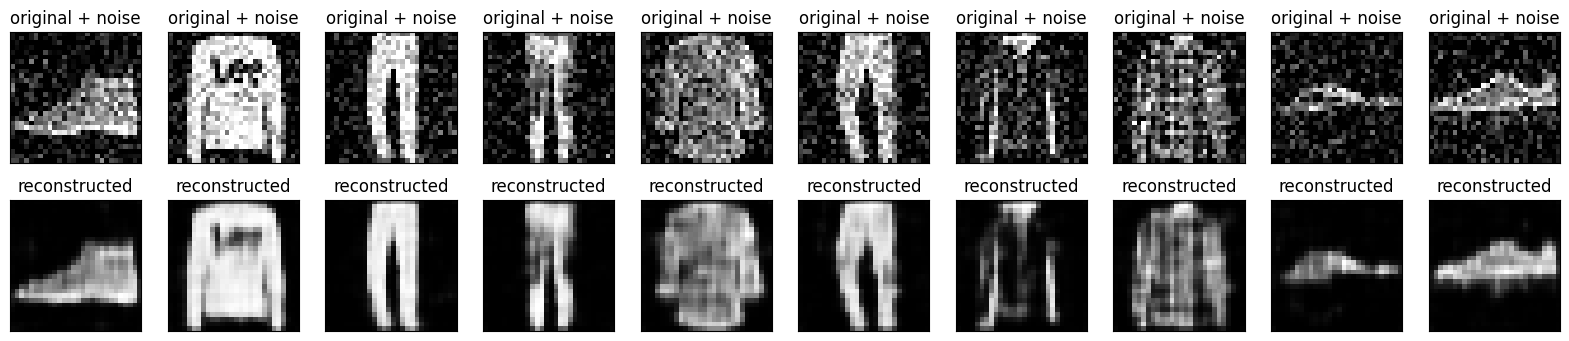

In [19]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Third example: Anomaly detection

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

### Load ECG data

The dataset you will use is based on one from [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000).


In [20]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [21]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

Normalize the data to `[0,1]`.


In [22]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as `1`. Separate the normal rhythms from the abnormal rhythms.

In [23]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Plot a normal ECG. 

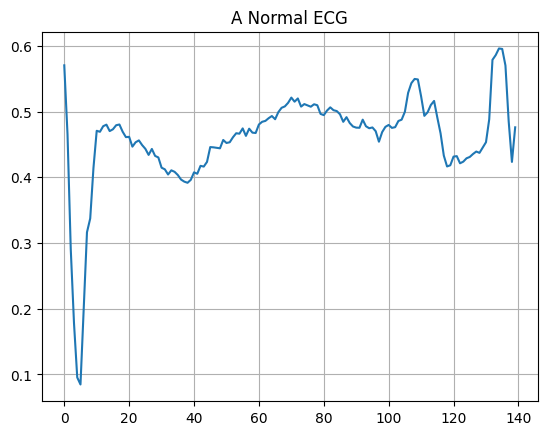

In [24]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

Plot an anomalous ECG.

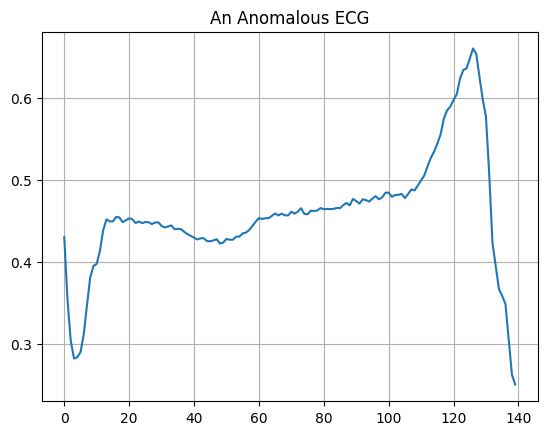

In [25]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### Build the model

In [26]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [27]:
autoencoder.compile(optimizer='adam', loss='mae')

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [28]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20


1/5 [=====>........................] - ETA: 8s - loss: 0.0581

5/5 [==============================] - 2s 46ms/step - loss: 0.0577 - val_loss: 0.0529


Epoch 2/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0565

5/5 [==============================] - 0s 16ms/step - loss: 0.0556 - val_loss: 0.0508


Epoch 3/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0537

5/5 [==============================] - 0s 16ms/step - loss: 0.0525 - val_loss: 0.0485


Epoch 4/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0501

5/5 [==============================] - 0s 15ms/step - loss: 0.0485 - val_loss: 0.0462


Epoch 5/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0456

5/5 [==============================] - 0s 15ms/step - loss: 0.0439 - val_loss: 0.0442


Epoch 6/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0414

5/5 [==============================] - 0s 15ms/step - loss: 0.0394 - val_loss: 0.0423


Epoch 7/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0372

5/5 [==============================] - 0s 15ms/step - loss: 0.0354 - val_loss: 0.0402


Epoch 8/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0333

5/5 [==============================] - 0s 15ms/step - loss: 0.0321 - val_loss: 0.0393


Epoch 9/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0307

5/5 [==============================] - 0s 15ms/step - loss: 0.0297 - val_loss: 0.0383


Epoch 10/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0280

5/5 [==============================] - 0s 15ms/step - loss: 0.0279 - val_loss: 0.0378


Epoch 11/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0272

5/5 [==============================] - 0s 15ms/step - loss: 0.0266 - val_loss: 0.0369


Epoch 12/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0259

5/5 [==============================] - 0s 15ms/step - loss: 0.0256 - val_loss: 0.0363


Epoch 13/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0251

5/5 [==============================] - 0s 15ms/step - loss: 0.0247 - val_loss: 0.0358


Epoch 14/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0247

5/5 [==============================] - 0s 15ms/step - loss: 0.0239 - val_loss: 0.0350


Epoch 15/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0226

5/5 [==============================] - 0s 15ms/step - loss: 0.0231 - val_loss: 0.0346


Epoch 16/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0225

5/5 [==============================] - 0s 15ms/step - loss: 0.0225 - val_loss: 0.0341


Epoch 17/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0227

5/5 [==============================] - 0s 15ms/step - loss: 0.0220 - val_loss: 0.0337


Epoch 18/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0221

5/5 [==============================] - 0s 15ms/step - loss: 0.0215 - val_loss: 0.0335


Epoch 19/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0205

5/5 [==============================] - 0s 15ms/step - loss: 0.0211 - val_loss: 0.0333


Epoch 20/20


1/5 [=====>........................] - ETA: 0s - loss: 0.0216

5/5 [==============================] - 0s 15ms/step - loss: 0.0208 - val_loss: 0.0334


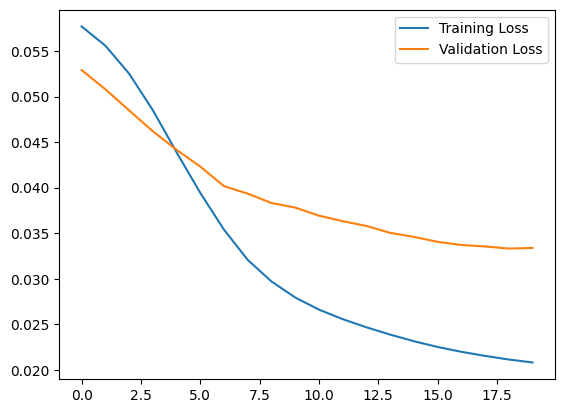

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

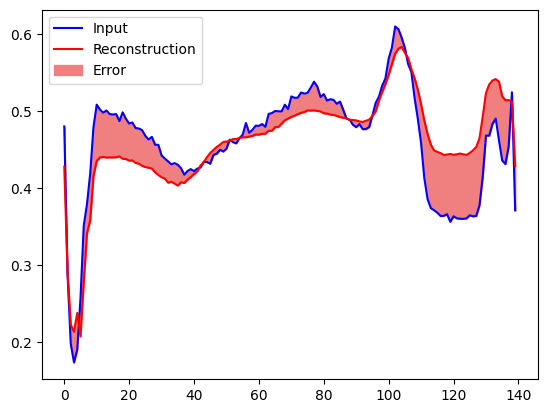

In [30]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

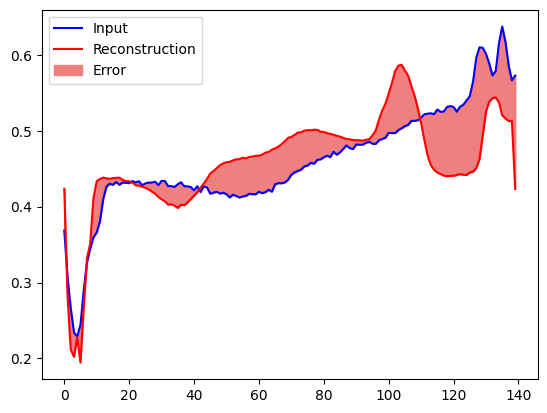

In [31]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### Detect anomalies

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.


Plot the reconstruction error on normal ECGs from the training set

 1/74 [..............................] - ETA: 8s

39/74 [==============>...............] - ETA: 0s

74/74 [==============================] - 0s 1ms/step


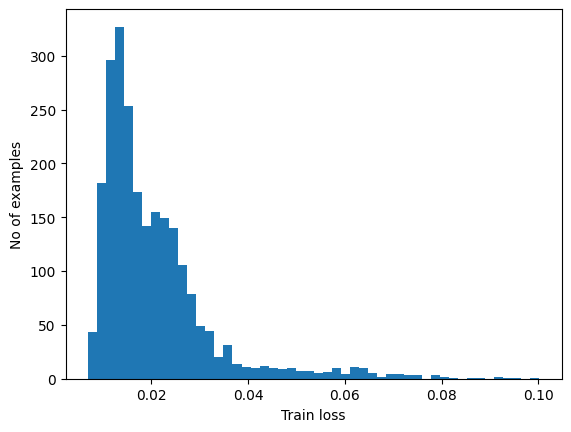

In [32]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [33]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03267927


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial. 

If you examine the reconstruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the [precision](https://developers.google.com/machine-learning/glossary#precision) and [recall](https://developers.google.com/machine-learning/glossary#recall) of your classifier. 

 1/14 [=>............................] - ETA: 0s

14/14 [==============================] - 0s 1ms/step


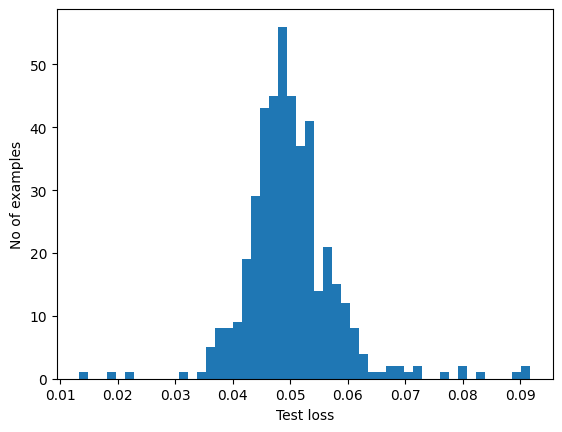

In [34]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [35]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [36]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.944
Precision = 0.9921875
Recall = 0.9071428571428571


## Next steps

To learn more about anomaly detection with autoencoders, check out this excellent [interactive example](https://anomagram.fastforwardlabs.com/#/) built with TensorFlow.js by Victor Dibia. For a real-world use case, you can learn how [Airbus Detects Anomalies in ISS Telemetry Data](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html) using TensorFlow. To learn more about the basics, consider reading this [blog post](https://blog.keras.io/building-autoencoders-in-keras.html) by François Chollet. For more details, check out chapter 14 from [Deep Learning](https://www.deeplearningbook.org/) by Ian Goodfellow, Yoshua Bengio, and Aaron Courville.
